# Task 3 - Cluster Analysis 2 - Soft Clustering

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- user types and patterns
- distance to city center patterns

- loaction demand patterns (Notebook: Task 3 - Cluster Analysis 3 - Location based Clustering)

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

In [2]:
# import datasets
df_chicago = pd.read_csv("../data/datasets/df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Score functions

When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

A lower BIC score for a number of clusters indicates a more suitable and optimal choice of clusters, since it takes into account the complexity of the model and penalizes it for being overly complex (helpful to avoid overfitting).

The silhouette score is defined as measuring the mean distance of each data point to points within a cluster and the nearest neighbour cluster. For the silhouette score a higher value for a specific number of clusters, is a better choice.

Functions for those methods:

#### Silhouette score

In [3]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

#### Bayesian information criterion (BIC)

In [4]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

### 2) Scaling function

#### Data scaling function:

Function for scaling the data to achieve more precise cluster results:

In [5]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df1)
    df_scaled = pd.DataFrame(df_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_scaled

### 3) Plotting functions:

#### Plot cluster information:

This function creates boxplots for the different clusters calculated before with another function. Furthermore it plots the amount of trips contained in the different clusters, using a countplot:

In [6]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

Plots clusters as a scatterplots (different scatterplots for the different features versus eacht other):

In [7]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

#### Plot scatter with convex hulls:

This functions also are there for plotting the clusters. They get plot as scatterplots again, but now we also going to plot hulls around them:

In [8]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()

### 4) Functions for calculations:

#### Function for quantiles

This function calculates the 0.25 and 0.75 quantiles of the clusters and builds a table containing the clusters, those quantiles, the amount of trips and percentage of all trips that are in the different clusters:

In [9]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

### 5) Functions for mapping clusters on city map

The following both functions create a map containing all clusters using the hexagon resolutions. The clusters are plotted in different colors:

In [10]:
def get_hex_ids_for_cluster_and_resolution(df, cluster_number, resolution):
    # Filter hex IDs for the specified cluster and resolution
    # Group hex IDs by cluster
    grouped_h3_hex_id = df.groupby('cluster')[resolution].apply(set).reset_index()
    
    # Get the list of hex IDs for clusters
    hex_ids_for_clusters = grouped_h3_hex_id[grouped_h3_hex_id['cluster'] == cluster_number][resolution].iloc[0]
    
    return hex_ids_for_clusters

In [11]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

<hr style="border: 1px solid #8888;">

## Preprocessing

### Preprocessing for clustering: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds` to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [12]:
df_chicago['Trip_Minutes'] = df_chicago['Trip_Seconds']/60
df_chicago.drop(['Trip_Seconds'], axis = 1,inplace =True)

In [13]:
df_chicago = df_chicago[(df_chicago['Trip_Miles'] < df_chicago['Trip_Miles'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['Trip_Minutes'] < df_chicago['Trip_Minutes'].quantile(0.95))]

In [14]:
# Drop unrealistic fast trips
df_chicago["velocity"] = (df_chicago["Trip_Miles"]/(df_chicago["Trip_Minutes"]/60)).round(2)
df_chicago = df_chicago[(df_chicago['velocity'] < df_chicago['velocity'].quantile(0.95))]
df_chicago = df_chicago[(df_chicago['velocity'] > df_chicago['velocity'].quantile(0.05))]
df_chicago = df_chicago.drop(['velocity'], axis = 1)

In [15]:
df_chicago.reset_index(inplace = True)

### Creating dataframe:

Here we create the dataframe `df_chicago_cluster` we are going to need later for Cluster Analysis 3.4:

In [16]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Minutes',"Trip_Miles"]]
df_chicago_cluster

start_time_hourly  Trip_Minutes  Trip_Miles
0                        0          15.0         2.7
1                        0           4.0         0.4
2                        0           3.0         1.0
3                        0           4.0         0.3
4                        0           8.0         0.8
...                    ...           ...         ...
7247312                 23           3.0         0.5
7247313                 23          19.0         5.1
7247314                 23           9.0         1.4
7247315                 23          12.0         2.0
7247316                 23          11.0         3.5

[7247317 rows x 3 columns]

### Preprocessing for location based clustering: 

#### Creating `distance_to_city_center_pickup` and `distance_to_city_center_dropoff`

Because we later cluster based on the start and end distance of a trip from city center, we need to create those features and add them to our dataframe. This is what we are doing in the follwing:

In [17]:
import dask.dataframe as dd
import math

# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

# Haversine function using Dask's map_partitions for distances in miles
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [18]:
ddfChicago = dd.from_pandas(pd.DataFrame(df_chicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_pickup'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Pickup_Centroid_Latitude'], df['Pickup_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
df_chicago = ddfChicago.compute()
df_chicago

index                                   Trip_ID  \
0              0  27ad87f629bf14fa3cb894daad514cdad4736f9c   
1              1  9a9d9902dfa267b88400a22a2c9f0cf74384b372   
2              3  6deda34a1a498737aaa64734fa2c09a0bf335f18   
3              4  faa2c909d0b88f3f54217135c6919a7fdd73a366   
4              5  234917c65329ac7ed139a7d87e2f1d9238955ba3   
...          ...                                       ...   
7247312  8974512  2f326845a0cd7cc6a8677587bb1ae32b95030e11   
7247313  8974514  6f0446f9dbc91bcd20e29e5b4b415c40310b0818   
7247314  8974515  eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8   
7247315  8974517  e93c3a7ee7050521d22a6d513b65d94642813a4c   
7247316  8974518  cf906408921ec94acfed42add2165ab0f52fe9b7   

                                                   Taxi_ID  \
0        4b38941e0745acdeefe630832a438a59fdaac78640f68a...   
1        1a1189d1e9f4f676bbeaf49903912684b94453576a234f...   
2        48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...   
3        2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...   
4        bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...   
...                                                    ...   
7247312  1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...   
7247313  bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...   
7247314  0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...   
7247315  9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...   
7247316  1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...   

        Trip_Start_Timestamp   Trip_End_Timestamp  Trip_Miles  \
0        2013-01-01 00:00:00  2013-01-01 00:00:00         2.7   
1        2013-01-01 00:00:00  2013-01-01 00:00:00         0.4   
2        2013-01-01 00:00:00  2013-01-01 00:00:00         1.0   
3        2013-01-01 00:00:00  2013-01-01 00:00:00         0.3   
4        2013-01-01 00:00:00  2013-01-01 00:00:00         0.8   
...                      ...                  ...         ...   
7247312  2013-12-31 23:00:00  2014-01-01 00:00:00         0.5   
7247313  2013-12-31 23:00:00  2014-01-01 00:00:00         5.1   
7247314  2013-12-31 23:00:00  2014-01-01 00:00:00         1.4   
7247315  2013-12-31 23:00:00  2014-01-01 00:00:00         2.0   
7247316  2013-12-31 23:00:00  2013-12-31 23:00:00         3.5   

         Pickup_Census_Tract  Dropoff_Census_Tract  Pickup_Community_Area  \
0                        NaN                   NaN                   28.0   
1               1.703107e+10          1.703107e+10                    7.0   
2                        NaN                   NaN                   24.0   
3               1.703128e+10          1.703132e+10                   28.0   
4                        NaN                   NaN                   22.0   
...                      ...                   ...                    ...   
7247312         1.703128e+10          1.703128e+10                   28.0   
7247313         1.703106e+10          1.703116e+10                    6.0   
7247314         1.703108e+10          1.703184e+10                    8.0   
7247315         1.703132e+10          1.703133e+10                   32.0   
7247316         1.703108e+10          1.703184e+10                    8.0   

         Dropoff_Community_Area  ...  humidity  temperature_celsius  \
0                           8.0  ...      64.0                -0.19   
1                           7.0  ...      64.0                -0.19   
2                          24.0  ...      64.0                -0.19   
3                          32.0  ...      64.0                -0.19   
4                          22.0  ...      64.0                -0.19   
...                         ...  ...       ...                  ...   
7247312                    28.0  ...      89.0               -11.00   
7247313                    16.0  ...      89.0               -11.00   
7247314                     8.0  ...      89.0               -11.00   
7247315                    33.0  ...      89.0               -11.00   
7247316                    33.0  .

In [19]:
ddfChicago = dd.from_pandas(pd.DataFrame(df_chicago), npartitions=8)  # Adjust npartitions as needed

ddfChicago['distance_to_city_center_dropoff'] = ddfChicago.map_partitions(
        lambda df: haversine(df['Dropoff_Centroid_Latitude'], df['Dropoff_Centroid_Longitude'], chicago_city_center[0], chicago_city_center[1]),
        meta=('distance_to_city_center', 'f8')
        )

# Compute the Dask DataFrame to get the final result
df_chicago = ddfChicago.compute()
df_chicago

index                                   Trip_ID  \
0              0  27ad87f629bf14fa3cb894daad514cdad4736f9c   
1              1  9a9d9902dfa267b88400a22a2c9f0cf74384b372   
2              3  6deda34a1a498737aaa64734fa2c09a0bf335f18   
3              4  faa2c909d0b88f3f54217135c6919a7fdd73a366   
4              5  234917c65329ac7ed139a7d87e2f1d9238955ba3   
...          ...                                       ...   
7247312  8974512  2f326845a0cd7cc6a8677587bb1ae32b95030e11   
7247313  8974514  6f0446f9dbc91bcd20e29e5b4b415c40310b0818   
7247314  8974515  eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8   
7247315  8974517  e93c3a7ee7050521d22a6d513b65d94642813a4c   
7247316  8974518  cf906408921ec94acfed42add2165ab0f52fe9b7   

                                                   Taxi_ID  \
0        4b38941e0745acdeefe630832a438a59fdaac78640f68a...   
1        1a1189d1e9f4f676bbeaf49903912684b94453576a234f...   
2        48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...   
3        2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...   
4        bd95c3ff6f1c2e98b999c76ac1573ea273c1aacd2ccc0b...   
...                                                    ...   
7247312  1df52fc60f8edec541c9a014b8ecf83c86f471b328635c...   
7247313  bfb5c2ad40103c9891e7ee4713e93ccd75e741099b7498...   
7247314  0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...   
7247315  9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...   
7247316  1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...   

        Trip_Start_Timestamp   Trip_End_Timestamp  Trip_Miles  \
0        2013-01-01 00:00:00  2013-01-01 00:00:00         2.7   
1        2013-01-01 00:00:00  2013-01-01 00:00:00         0.4   
2        2013-01-01 00:00:00  2013-01-01 00:00:00         1.0   
3        2013-01-01 00:00:00  2013-01-01 00:00:00         0.3   
4        2013-01-01 00:00:00  2013-01-01 00:00:00         0.8   
...                      ...                  ...         ...   
7247312  2013-12-31 23:00:00  2014-01-01 00:00:00         0.5   
7247313  2013-12-31 23:00:00  2014-01-01 00:00:00         5.1   
7247314  2013-12-31 23:00:00  2014-01-01 00:00:00         1.4   
7247315  2013-12-31 23:00:00  2014-01-01 00:00:00         2.0   
7247316  2013-12-31 23:00:00  2013-12-31 23:00:00         3.5   

         Pickup_Census_Tract  Dropoff_Census_Tract  Pickup_Community_Area  \
0                        NaN                   NaN                   28.0   
1               1.703107e+10          1.703107e+10                    7.0   
2                        NaN                   NaN                   24.0   
3               1.703128e+10          1.703132e+10                   28.0   
4                        NaN                   NaN                   22.0   
...                      ...                   ...                    ...   
7247312         1.703128e+10          1.703128e+10                   28.0   
7247313         1.703106e+10          1.703116e+10                    6.0   
7247314         1.703108e+10          1.703184e+10                    8.0   
7247315         1.703132e+10          1.703133e+10                   32.0   
7247316         1.703108e+10          1.703184e+10                    8.0   

         Dropoff_Community_Area  ...  temperature_celsius  wind_direction  \
0                           8.0  ...                -0.19           200.0   
1                           7.0  ...                -0.19           200.0   
2                          24.0  ...                -0.19           200.0   
3                          32.0  ...                -0.19           200.0   
4                          22.0  ...                -0.19           200.0   
...                         ...  ...                  ...             ...   
7247312                    28.0  ...               -11.00           217.0   
7247313                    16.0  ...               -11.00           217.0   
7247314                     8.0  ...               -11.00           217.0   
7247315                    33.0  ...         

<hr style="border: 1px solid #8888;">

## 3.0 Cluster Analysis

Now we are starting with our cluster analysis. The first four cluster analysis are there for finding user types and patterns, while we perfomed the last ones to look if we observe some distance to city center patterns. All sections/analysis are going to be performed with the same order of steps, which are the following:

- create the dataframe containing the features we need to perform these analysis
- scaling the data of these frames for achieving more precise clusters
- Validation of Number of Clusters: using silhouette and BIC score for getting the best number of clusters. Here we always take a sample of the dataframes, since they contain too much values and the run time for calculating the scores would be too long
- Computing Clusters with Gaussian Mixture Model: as the heading suggests in this subsection we calculate the clusters
- Analyzing and labeling clusters: in this part we plot the clusters in barplots, looking at the quantiles and based on this label the produced clusters
- Plotting the Clustering Results: in this part we plot the clusters in scatterplots
- Displaying Results on a Map of Chicago: for section 5 and 6 we also plot the clusters on a map of Chicago
- Evaluation: here we describe the labels we chose for the calculated clusters

<hr style="border: 1px solid #8888;">

## 3.1 First Cluster Analysis: `start_time_hourly`

In [18]:
df_cluster_start = df_chicago_cluster[['start_time_hourly']]

#### Scaling the data:

In [19]:
df_start_scaled = scaling_data(df_cluster_start)

### 3.1.1 Validation of Number of Clusters

In [55]:
df_score = df_start_scaled.sample(350000, random_state=42)
df_score

start_time_hourly
7859463          -1.983130
1567295          -1.983130
1532308          -0.670610
8608880           1.225252
1538808           0.350239
...                    ...
3671881           1.225252
4277237           0.787746
5670711          -0.233104
8230356           1.225252
7144796           1.079417

[350000 rows x 1 columns]

### Silhouette score

In [15]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

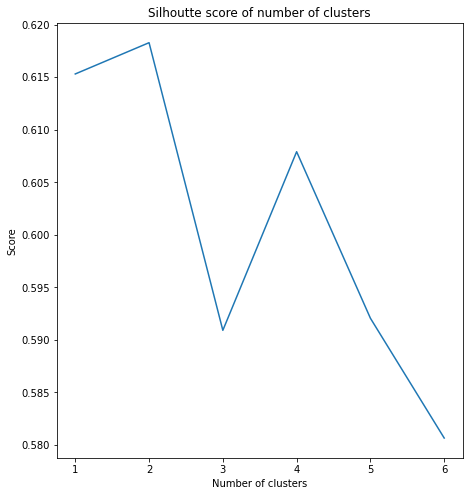

In [16]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [17]:
clusters_bic, scores_bic = bic(df_score, 6)

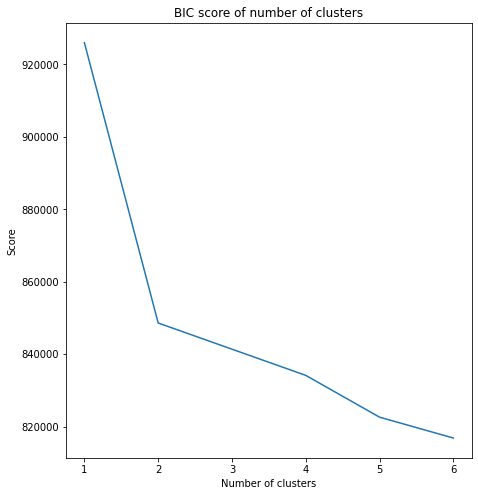

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

We decide to choose 4 clusters, since we have a peak in the silhouette score and the BIC score decreases from a number of 2, so is relatively low at 4.

### 3.1.2 Computing Clusters with Gaussian Mixture Model

In [20]:
gm = GaussianMixture(n_components=4, random_state=42, n_init = 15).fit(df_start_scaled)

In [21]:
cluster = gm.predict(df_start_scaled)

In [22]:
cluster_prob = gm.predict_proba(df_start_scaled)

In [23]:
df_cluster_start["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/1123111176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_start["cluster"] = cluster


In [24]:
for k in range(4):
    df_cluster_start[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [25]:
df_cluster_start

start_time_hourly  cluster  cluster_0_prob  cluster_1_prob  \
0                        0        2        0.001549    8.116161e-19   
1                        0        2        0.001549    8.116161e-19   
2                        0        2        0.001549    8.116161e-19   
3                        0        2        0.001549    8.116161e-19   
4                        0        2        0.001549    8.116161e-19   
...                    ...      ...             ...             ...   
7247312                 23        3        0.000185    3.081451e-02   
7247313                 23        3        0.000185    3.081451e-02   
7247314                 23        3        0.000185    3.081451e-02   
7247315                 23        3        0.000185    3.081451e-02   
7247316                 23        3        0.000185    3.081451e-02   

         cluster_2_prob  cluster_3_prob  
0          9.984511e-01    1.372281e-57  
1          9.984511e-01    1.372281e-57  
2          9.984511e-01    1.372281e-57  
3          9.984511e-01    1.372281e-57  
4          9.984511e-01    1.372281e-57  
...                 ...             ...  
7247312    4.584967e-60    9.690002e-01  
7247313    4.584967e-60    9.690002e-01  
7247314    4.584967e-60    9.690002e-01  
7247315    4.584967e-60    9.690002e-01  
7247316    4.584967e-60    9.690002e-01  

[7247317 rows x 6 columns]

### 3.1.3 Analyzing & Labeling clusters

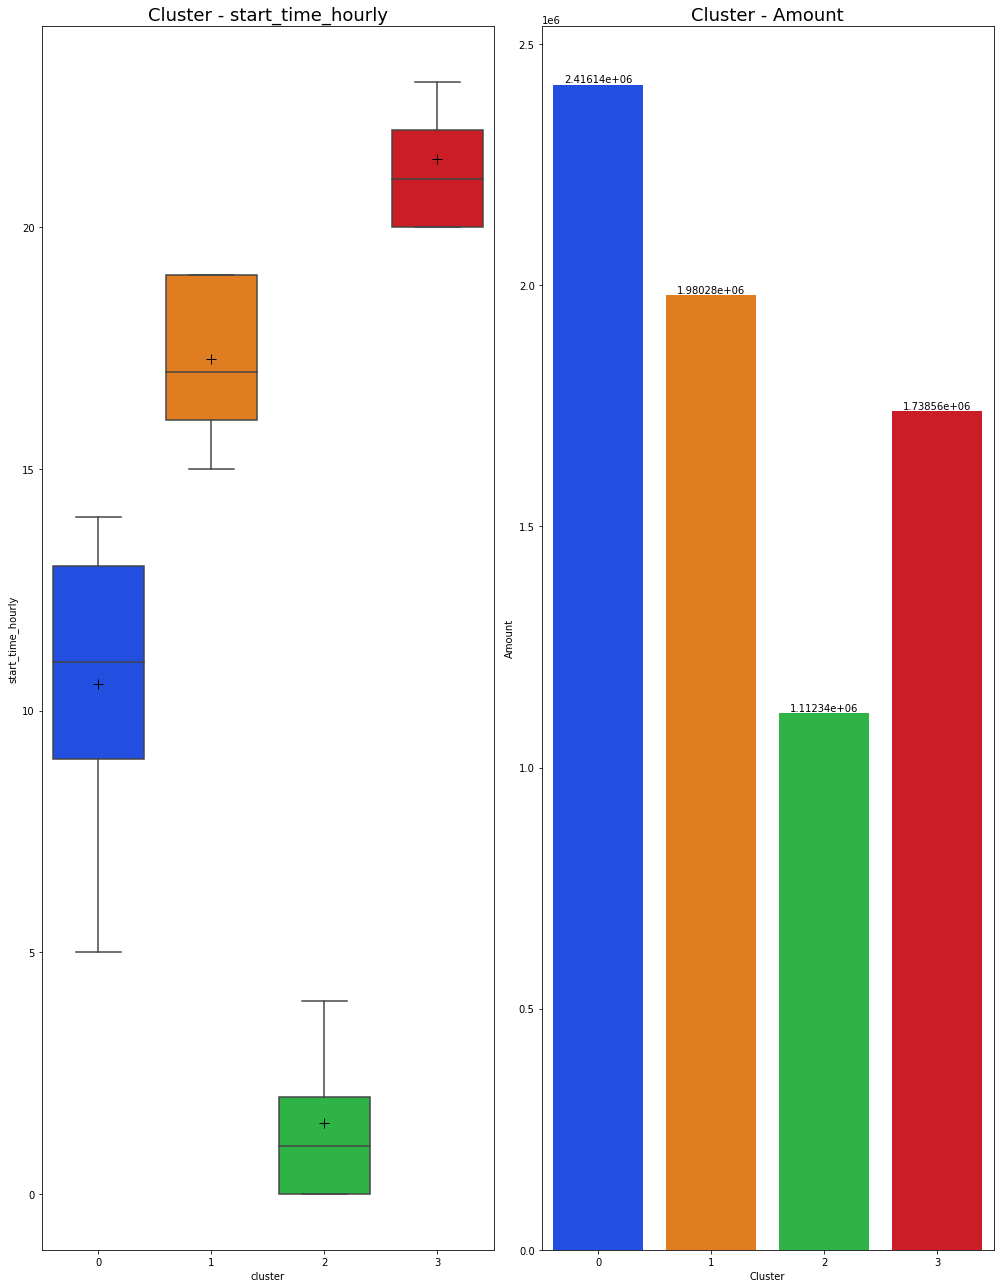

In [26]:
plot_information_about_clusters(df_cluster_start, ['start_time_hourly'], 'cluster')

In [28]:
dfChicago_clu_start_time_quantiles = get_quantiles_of_clusters(df_cluster_start, 4, 'cluster')
dfChicago_clu_start_time_quantiles

start_time_hourly cluster_0_prob cluster_1_prob cluster_2_prob  \
Cluster                                                                  
0              9.0 - 13.0     0.92 - 1.0     0.0 - 0.08      0.0 - 0.0   
1             16.0 - 19.0    0.01 - 0.19    0.74 - 0.92      0.0 - 0.0   
2               0.0 - 2.0     0.0 - 0.01      0.0 - 0.0     0.99 - 1.0   
3             20.0 - 22.0      0.0 - 0.0    0.06 - 0.38      0.0 - 0.0   

        cluster_3_prob  Amount Trips in Cluster  Percentage  
Cluster                                                      
0            0.0 - 0.0                2416138.0       33.34  
1           0.0 - 0.24                1980282.0       27.32  
2            0.0 - 0.0                1112340.0       15.35  
3          0.61 - 0.94                1738557.0       23.99

In [29]:
label_names = {'0': "Morning (before work) Commuters", 
               '1': "Evening (after work) Commuters",
               '2': "Night Riders - Party People",
              '3': "Evening Customers"}

# integrating our labeled clusters in the dataframe
df_cluster_start['Cluster_Label'] = df_cluster_start['cluster'].astype(str)
df_cluster_start = df_cluster_start.replace({"Cluster_Label": label_names})

In [30]:
dfChicago_clu_start_time_index = df_cluster_start
dfChicago_clu_start_time_index['Trip_Index'] = df_cluster_start.index
dfChicago_clu_start_time_index

start_time_hourly  cluster  cluster_0_prob  cluster_1_prob  \
0                        0        2        0.001549    8.116161e-19   
1                        0        2        0.001549    8.116161e-19   
2                        0        2        0.001549    8.116161e-19   
3                        0        2        0.001549    8.116161e-19   
4                        0        2        0.001549    8.116161e-19   
...                    ...      ...             ...             ...   
7247312                 23        3        0.000185    3.081451e-02   
7247313                 23        3        0.000185    3.081451e-02   
7247314                 23        3        0.000185    3.081451e-02   
7247315                 23        3        0.000185    3.081451e-02   
7247316                 23        3        0.000185    3.081451e-02   

         cluster_2_prob  cluster_3_prob                Cluster_Label  \
0          9.984511e-01    1.372281e-57  Night Riders - Party People   
1          9.984511e-01    1.372281e-57  Night Riders - Party People   
2          9.984511e-01    1.372281e-57  Night Riders - Party People   
3          9.984511e-01    1.372281e-57  Night Riders - Party People   
4          9.984511e-01    1.372281e-57  Night Riders - Party People   
...                 ...             ...                          ...   
7247312    4.584967e-60    9.690002e-01            Evening Customers   
7247313    4.584967e-60    9.690002e-01            Evening Customers   
7247314    4.584967e-60    9.690002e-01            Evening Customers   
7247315    4.584967e-60    9.690002e-01            Evening Customers   
7247316    4.584967e-60    9.690002e-01            Evening Customers   

         Trip_Index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
7247312     7247312  
7247313     7247313  
7247314     7247314  
7247315     7247315  
7247316     7247316  

[7247317 rows x 8 columns]

### 3.1.4 Plotting the Clustering Results

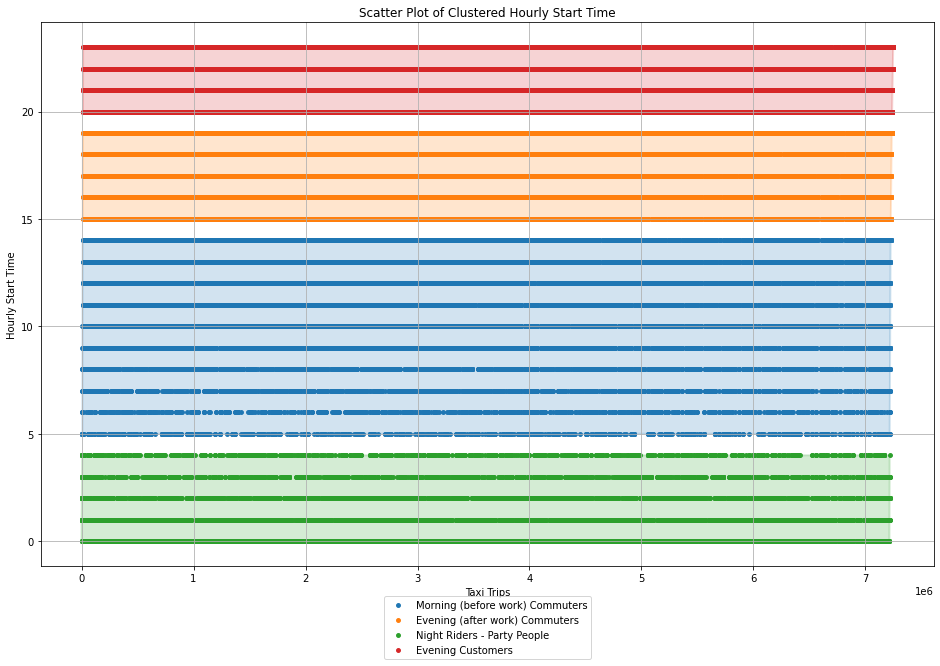

In [31]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_start_time_index.sample(n=100000), x_col='Trip_Index', y_col='start_time_hourly', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Hourly Start Time", plot_title='Scatter Plot of Clustered Hourly Start Time', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.1.5 Evaluation

`Cluster 0 -` __Morning (before work) Commuters__ <br>
This cluster represents the commuters who are taking a taxi for driving to work.

`Cluster 1 -` __Evening (after work) Commuters__  <br>
This cluster is the same as Cluster 0 with the difference, that it represents the people who are driving after work (so home from work).

`Cluster 2 -` __Night Riders - Party People__  <br>
We here have the cluster containing all people who are driving at night just for example party people driving home after partying.

`Cluster 3 -` __Evening Customers__  <br>
This cluster shows all customers driving with a taxi in the evening hours (late after work, but before the Night Riders). That can be people driving to party, eating dinner or going in the cinema (just as examples).

<hr style="border: 1px solid #8888;">

## 3.2 Second Cluster Analysis: `Trip_Miles`

#### Scaling the data:

In [32]:
df_cluster_miles = df_chicago_cluster[['Trip_Miles']]

In [33]:
df_miles_scaled = scaling_data(df_cluster_miles)

### 3.2.1 Validation of Number of Clusters

In [73]:
df_score = df_miles_scaled.sample(350000, random_state=42)
df_score

Trip_Miles
7859463   -1.123370
1567295   -1.046943
1532308   -0.511955
8608880   -1.215082
1538808   -0.817662
...             ...
3671881    0.099460
4277237    1.093009
5670711   -0.817662
8230356   -0.917017
7144796   -0.282674

[350000 rows x 1 columns]

### Silhouette score

In [29]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

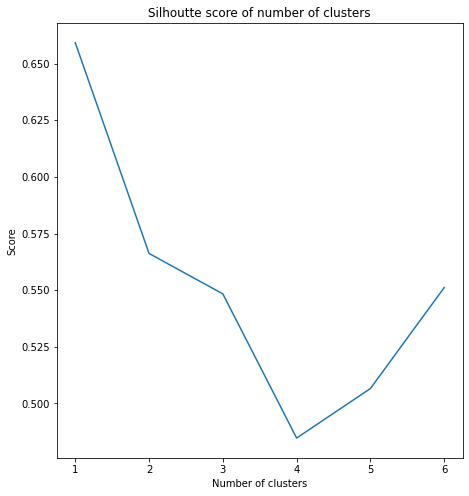

In [30]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [31]:
clusters_bic, scores_bic = bic(df_score, 6)

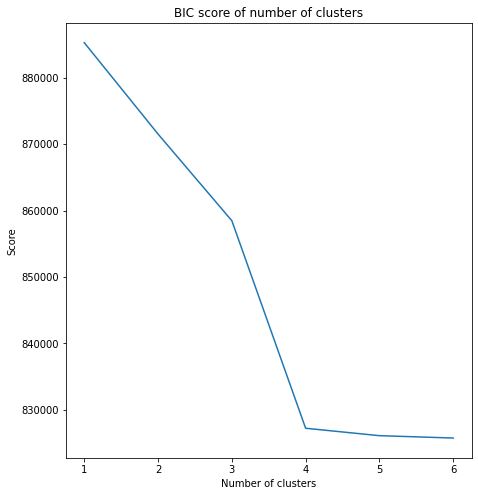

In [32]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

Here we decide for 3 as the number of clusters to work with, because there the BIC score has a drop and the silhouette score is is still quite high there. Since it is not an appropriate choice to slect too many clusters, we decided against using five or more here.

### 3.2.2 Computing Clusters with Gaussian Mixture Model

In [34]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_miles_scaled)

In [35]:
cluster = gm.predict(df_miles_scaled)

In [36]:
cluster_prob = gm.predict_proba(df_miles_scaled)

In [37]:
df_cluster_miles["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/2624358545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_miles["cluster"] = cluster


In [38]:
for k in range(3):
    df_cluster_miles[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [39]:
df_cluster_miles

Trip_Miles  cluster  cluster_0_prob  cluster_1_prob  cluster_2_prob
0               2.7        2    2.467813e-04        0.265397        0.734356
1               0.4        0    9.577545e-01        0.003228        0.039017
2               1.0        0    8.300077e-01        0.008476        0.161516
3               0.3        0    9.636555e-01        0.003140        0.033205
4               0.8        0    9.010509e-01        0.005352        0.093597
...             ...      ...             ...             ...             ...
7247312         0.5        0    9.495735e-01        0.003457        0.046970
7247313         5.1        1    4.687840e-20        0.999945        0.000055
7247314         1.4        0    5.023625e-01        0.025430        0.472207
7247315         2.0        2    3.966150e-02        0.080708        0.879630
7247316         3.5        1    4.456579e-08        0.823031        0.176969

[7247317 rows x 5 columns]

### 3.2.3 Analyzing & Labeling clusters

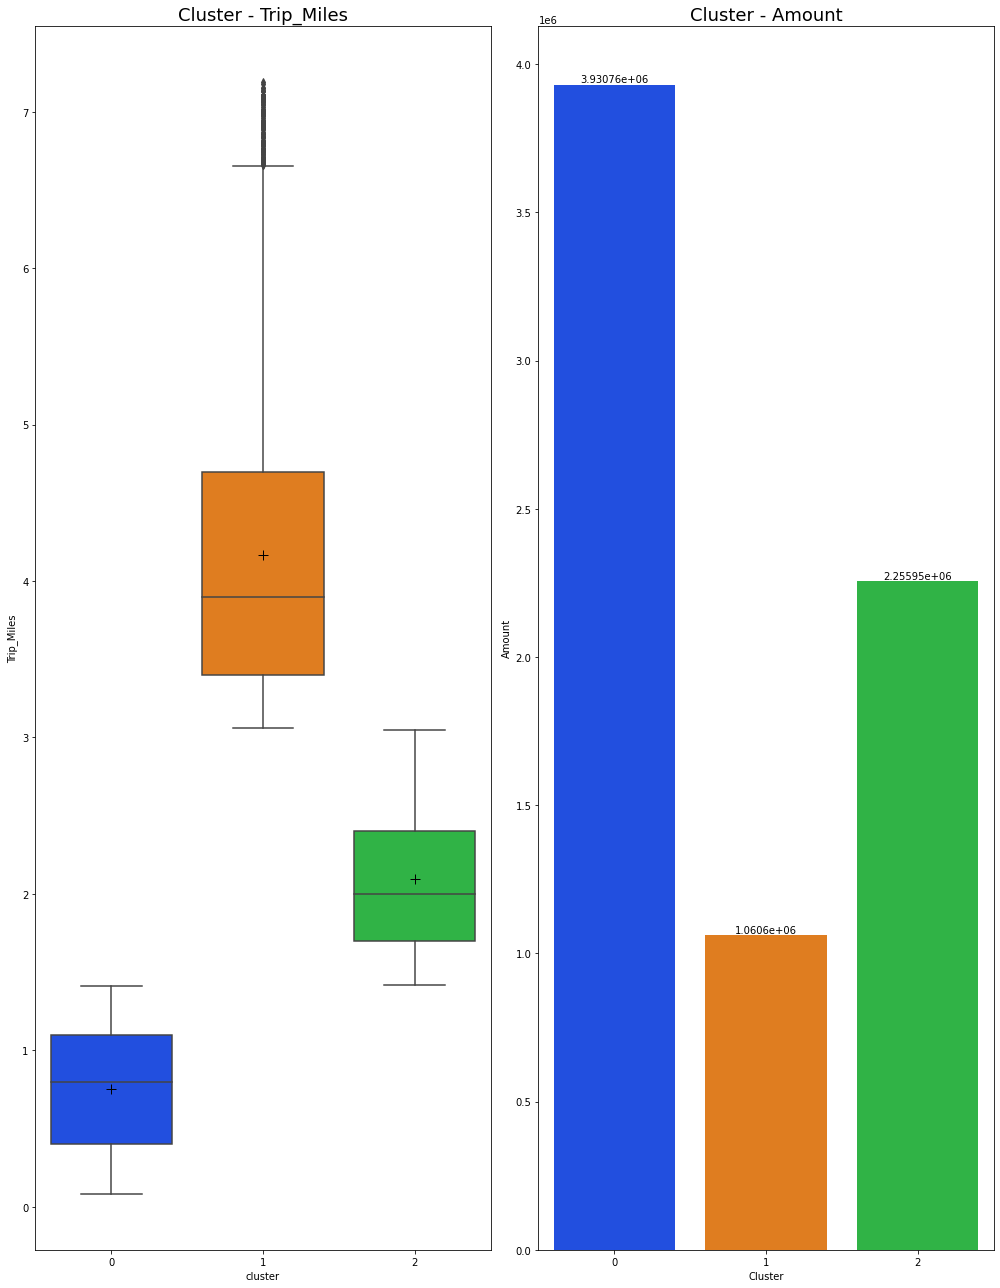

In [40]:
plot_information_about_clusters(df_cluster_miles, ['Trip_Miles'], 'cluster')

In [41]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_miles, 3, 'cluster')
dfChicago_clu_miles_time_quantiles

Trip_Miles cluster_0_prob cluster_1_prob cluster_2_prob  \
Cluster                                                           
0        0.4 - 1.1    0.77 - 0.96     0.0 - 0.01    0.04 - 0.21   
1        3.4 - 4.7      0.0 - 0.0     0.76 - 1.0     0.0 - 0.24   
2        1.7 - 2.4     0.0 - 0.19    0.05 - 0.15    0.68 - 0.86   

         Amount Trips in Cluster  Percentage  
Cluster                                       
0                      3930764.0       54.24  
1                      1060600.0       14.63  
2                      2255953.0       31.13

In [42]:
label_names = {'0': "Short Trips", 
               '1': "Long Trips",
               '2': "Medium Trips"}

# integrating our labeled clusters in the dataframe
df_cluster_miles['Cluster_Label'] = df_cluster_miles['cluster'].astype(str)
df_cluster_miles = df_cluster_miles.replace({"Cluster_Label": label_names})

In [43]:
dfChicago_clu_miles_index = df_cluster_miles
dfChicago_clu_miles_index['Trip_Index'] = df_cluster_miles.index
dfChicago_clu_miles_index

Trip_Miles  cluster  cluster_0_prob  cluster_1_prob  cluster_2_prob  \
0               2.7        2    2.467813e-04        0.265397        0.734356   
1               0.4        0    9.577545e-01        0.003228        0.039017   
2               1.0        0    8.300077e-01        0.008476        0.161516   
3               0.3        0    9.636555e-01        0.003140        0.033205   
4               0.8        0    9.010509e-01        0.005352        0.093597   
...             ...      ...             ...             ...             ...   
7247312         0.5        0    9.495735e-01        0.003457        0.046970   
7247313         5.1        1    4.687840e-20        0.999945        0.000055   
7247314         1.4        0    5.023625e-01        0.025430        0.472207   
7247315         2.0        2    3.966150e-02        0.080708        0.879630   
7247316         3.5        1    4.456579e-08        0.823031        0.176969   

        Cluster_Label  Trip_Index  
0        Medium Trips           0  
1         Short Trips           1  
2         Short Trips           2  
3         Short Trips           3  
4         Short Trips           4  
...               ...         ...  
7247312   Short Trips     7247312  
7247313    Long Trips     7247313  
7247314   Short Trips     7247314  
7247315  Medium Trips     7247315  
7247316    Long Trips     7247316  

[7247317 rows x 7 columns]

### 3.2.4 Plotting the Clustering Results

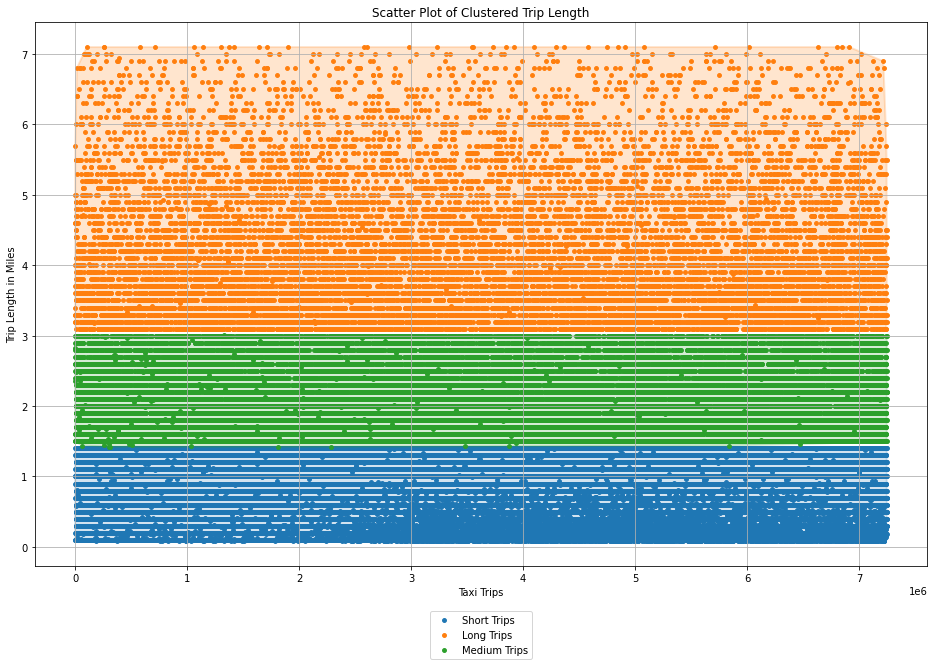

In [44]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_miles_index.sample(n=100000), x_col='Trip_Index', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Length in Miles", plot_title='Scatter Plot of Clustered Trip Length', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.2.5 Evaluation

`Cluster 0 -` __Short Trips__ <br>
This cluster represents the trips which are short, so only driving for few miles (up to 1.1 miles).

`Cluster 1 -` __Long Trips__  <br>
This cluster is the reverse cluster to Cluster 0. These are the trips which are long (trips for many miles: 3.4 - 4.7).

`Cluster 2 -` __Medium Trips__  <br>
This cluster contains the trips which are neither long nor short, so medium number of miles.

<hr style="border: 1px solid #8888;">

## 3.3 Third Cluster Analysis: `Trip_Minutes`

#### Scaling the data:

In [87]:
df_cluster_minutes = df_chicago_cluster[['Trip_Minutes']]

In [88]:
df_minutes_scaled = scaling_data(df_cluster_minutes)

### 3.3.1 Validation of Number of Clusters

In [35]:
df_score = df_minutes_scaled.sample(350000, random_state=42)
df_score

Trip_Minutes
7859463      0.403036
1567295      0.873073
1532308     -0.537038
8608880     -1.477111
1538808     -1.242093
...               ...
3671881      0.403036
4277237     -0.302019
5670711     -1.007074
8230356      0.403036
7144796     -0.537038

[350000 rows x 1 columns]

### Silhouette score

In [36]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

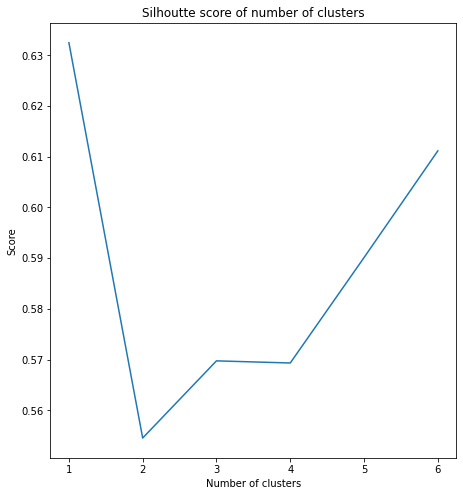

In [37]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [38]:
clusters_bic, scores_bic = bic(df_score, 6)

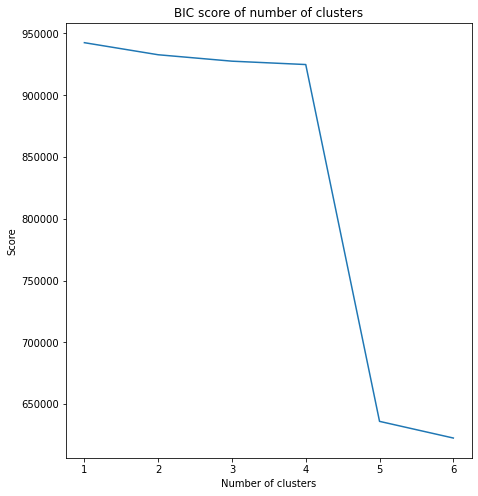

In [39]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

For this clustering we choose a number of five clusters. Because looking especially on the BIC score less clusters are not appropriate and for 5 clusters the silhouette score also increases.

### 3.3.2 Computing Clusters with Gaussian Mixture Model

In [89]:
gm = GaussianMixture(n_components=5, random_state=42, n_init = 15).fit(df_minutes_scaled)

In [90]:
cluster = gm.predict(df_minutes_scaled)

In [91]:
cluster_prob = gm.predict_proba(df_minutes_scaled)

In [92]:
df_cluster_minutes["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_30415/333786254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes["cluster"] = cluster


In [93]:
for k in range(5):
    df_cluster_minutes[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_30415/3876906274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_30415/3876906274.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_30415/3876906274.py:2: SettingWithCopyWarning: 
A value is trying to be set

In [94]:
df_cluster_minutes

Trip_Minutes  cluster  cluster_0_prob  cluster_1_prob  \
0                15.0        1    1.405756e-13    9.341037e-01   
1                 4.0        4    2.769192e-01    1.012760e-10   
2                 3.0        4    7.314536e-02    1.707580e-12   
3                 4.0        4    2.769192e-01    1.012760e-10   
4                 8.0        2    3.014629e-01    1.596802e-04   
...               ...      ...             ...             ...   
7247312           3.0        4    7.314536e-02    1.707580e-12   
7247313          19.0        3    1.043470e-27    1.197706e-02   
7247314           9.0        2    4.462110e-02    1.815642e-03   
7247315          12.0        2    2.595991e-06    3.227218e-01   
7247316          11.0        2    1.282735e-04    7.996147e-02   

         cluster_2_prob  cluster_3_prob  cluster_4_prob  
0              0.027459    3.843684e-02    2.862332e-87  
1              0.008584    7.183772e-26    7.144964e-01  
2              0.002420    3.100481e-29    9.244350e-01  
3              0.008584    7.183772e-26    7.144964e-01  
4              0.698377    7.139574e-14    1.130001e-13  
...                 ...             ...             ...  
7247312        0.002420    3.100481e-29    9.244350e-01  
7247313        0.000008    9.880146e-01   1.405753e-158  
7247314        0.953563    1.649837e-11    3.122675e-20  
7247315        0.677264    1.123667e-05    1.062027e-47  
7247316        0.919910    2.027616e-07    2.965631e-37  

[7247317 rows x 7 columns]

### 3.3.3 Analyzing & Labeling clusters

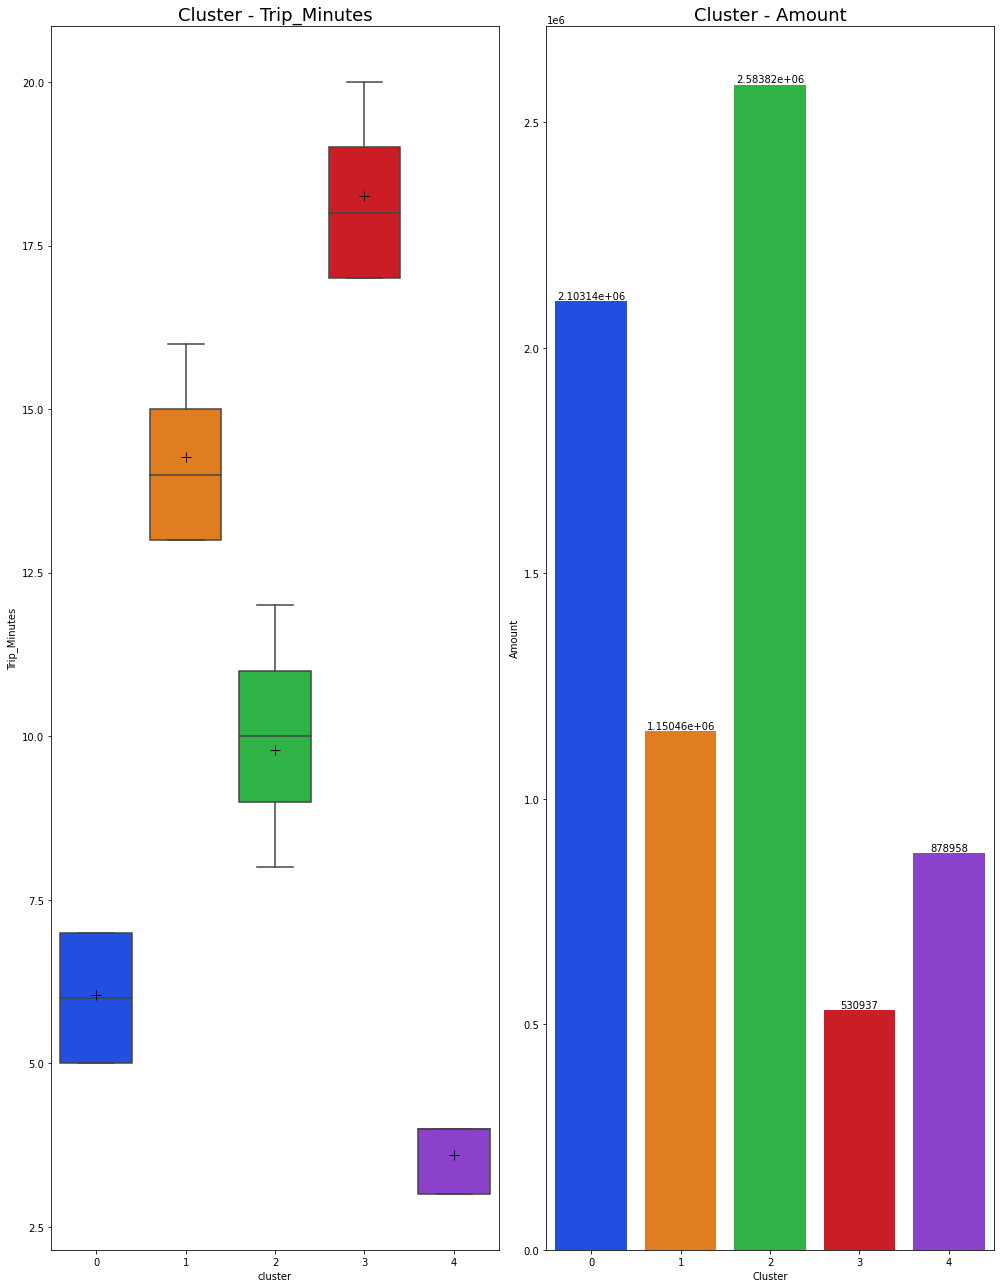

In [95]:
plot_information_about_clusters(df_cluster_minutes, ['Trip_Minutes'], 'cluster')

In [96]:
dfChicago_clu_minutes_quantiles = get_quantiles_of_clusters(df_cluster_minutes, 5, 'cluster')
dfChicago_clu_minutes_quantiles

Trip_Minutes cluster_0_prob cluster_1_prob cluster_2_prob  \
Cluster                                                             
0          5.0 - 7.0    0.72 - 0.91      0.0 - 0.0    0.04 - 0.28   
1        13.0 - 15.0      0.0 - 0.0     0.69 - 0.9    0.03 - 0.31   
2         9.0 - 11.0     0.0 - 0.04     0.0 - 0.08     0.7 - 0.95   
3        17.0 - 19.0      0.0 - 0.0    0.01 - 0.29      0.0 - 0.0   
4          3.0 - 4.0    0.07 - 0.28      0.0 - 0.0     0.0 - 0.01   

        cluster_3_prob cluster_4_prob  Amount Trips in Cluster  Percentage  
Cluster                                                                     
0            0.0 - 0.0     0.0 - 0.05                2103142.0       29.02  
1           0.0 - 0.04      0.0 - 0.0                1150461.0       15.87  
2            0.0 - 0.0      0.0 - 0.0                2583819.0       35.65  
3           0.7 - 0.99      0.0 - 0.0                 530937.0        7.33  
4            0.0 - 0.0    0.71 - 0.92                 878958.0       12.13

In [97]:
label_names = {'0': "Short Medium Customers", 
               '1': "Long Medium Customers",
               '2': "Medium Trips",
              '3': "Long Trips",
               '4': "Short Trips"}

# integrating our labeled clusters in the dataframe
df_cluster_minutes['Cluster_Label'] = df_cluster_minutes['cluster'].astype(str)
df_cluster_minutes = df_cluster_minutes.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_30415/3794032714.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes['Cluster_Label'] = df_cluster_minutes['cluster'].astype(str)


In [98]:
dfChicago_clu_minutes_index = df_cluster_minutes
dfChicago_clu_minutes_index['Trip_Index'] = df_cluster_minutes.index
dfChicago_clu_minutes_index

Trip_Minutes  cluster  cluster_0_prob  cluster_1_prob  \
0                15.0        1    1.405756e-13    9.341037e-01   
1                 4.0        4    2.769192e-01    1.012760e-10   
2                 3.0        4    7.314536e-02    1.707580e-12   
3                 4.0        4    2.769192e-01    1.012760e-10   
4                 8.0        2    3.014629e-01    1.596802e-04   
...               ...      ...             ...             ...   
7247312           3.0        4    7.314536e-02    1.707580e-12   
7247313          19.0        3    1.043470e-27    1.197706e-02   
7247314           9.0        2    4.462110e-02    1.815642e-03   
7247315          12.0        2    2.595991e-06    3.227218e-01   
7247316          11.0        2    1.282735e-04    7.996147e-02   

         cluster_2_prob  cluster_3_prob  cluster_4_prob  \
0              0.027459    3.843684e-02    2.862332e-87   
1              0.008584    7.183772e-26    7.144964e-01   
2              0.002420    3.100481e-29    9.244350e-01   
3              0.008584    7.183772e-26    7.144964e-01   
4              0.698377    7.139574e-14    1.130001e-13   
...                 ...             ...             ...   
7247312        0.002420    3.100481e-29    9.244350e-01   
7247313        0.000008    9.880146e-01   1.405753e-158   
7247314        0.953563    1.649837e-11    3.122675e-20   
7247315        0.677264    1.123667e-05    1.062027e-47   
7247316        0.919910    2.027616e-07    2.965631e-37   

                 Cluster_Label  Trip_Index  
0        Long Medium Customers           0  
1                  Short Trips           1  
2                  Short Trips           2  
3                  Short Trips           3  
4                 Medium Trips           4  
...                        ...         ...  
7247312            Short Trips     7247312  
7247313             Long Trips     7247313  
7247314           Medium Trips     7247314  
7247315           Medium Trips     7247315  
7247316           Medium Trips     7247316  

[7247317 rows x 9 columns]

### 3.3.4 Plotting the Clustering Results

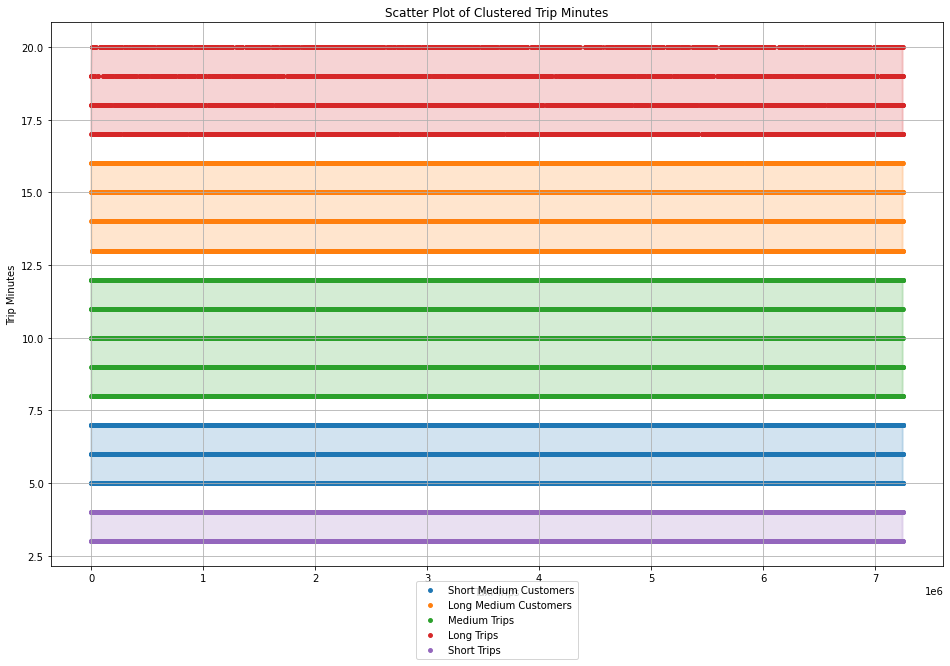

In [99]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_minutes_index.sample(n=100000), x_col='Trip_Index', y_col='Trip_Minutes', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Trip Minutes", plot_title='Scatter Plot of Clustered Trip Minutes', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.3.5 Evaluation

`Cluster 0 -` __Short Medium Customers__ <br>
This cluster represents the trips that are between the short and the medium long trips, when looking at the driving time.

`Cluster 1 -` __Long Medium Customers__  <br>
The opposite from cluster 0 as ist represents the trips which have a driving time between the long and the medium trips.

`Cluster 2 -` __Medium Trips__  <br>
We here have the cluster containing all trips that a medium long driving time.

`Cluster 3 -` __Long Trips__  <br>
Here, in this cluster, the trips that are very long are contained (from 17 up to 20 minutes).

`Cluster 4 -` __Short Trips__  <br>
This cluster shows all trips where the drive only goes a couple minutes (3-4 minutes).

<hr style="border: 1px solid #8888;">

## 3.4 Fourth Cluster Analysis: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

#### Scaling the data:

In [64]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [65]:
df_cluster_scaled

start_time_hourly  Trip_Minutes  Trip_Miles
0                -1.983130      1.343110    0.787302
1                -1.983130     -1.242093   -0.970516
2                -1.983130     -1.477111   -0.511955
3                -1.983130     -1.242093   -1.046943
4                -1.983130     -0.302019   -0.664808
...                    ...           ...         ...
7247312           1.371088     -1.477111   -0.894089
7247313           1.371088      2.283184    2.621546
7247314           1.371088     -0.067001   -0.206247
7247315           1.371088      0.638055    0.252314
7247316           1.371088      0.403036    1.398717

[7247317 rows x 3 columns]

### 3.4.1 Validation of Number of Clusters

In [27]:
df_score = df_cluster_scaled.sample(750000, random_state=42)
df_score

start_time_hourly  Trip_Miles  Trip_Minutes
7859463          -1.983130   -1.123370      0.403036
1567295          -1.983130   -1.046943      0.873073
1532308          -0.670610   -0.511955     -0.537038
8608880           1.225252   -1.215082     -1.477111
1538808           0.350239   -0.817662     -1.242093
...                    ...         ...           ...
5094111          -0.670610   -0.129820     -0.772056
1702540           0.496074   -0.741235     -1.477111
7783643          -1.545624   -0.664808     -1.242093
4667153           0.350239   -1.123370     -0.067001
4629742          -0.816446   -0.817662     -1.007074

[750000 rows x 3 columns]

### Silhouette score

In [28]:
#clusters_sil, scores_sil = silhoutte(df_score, 10)

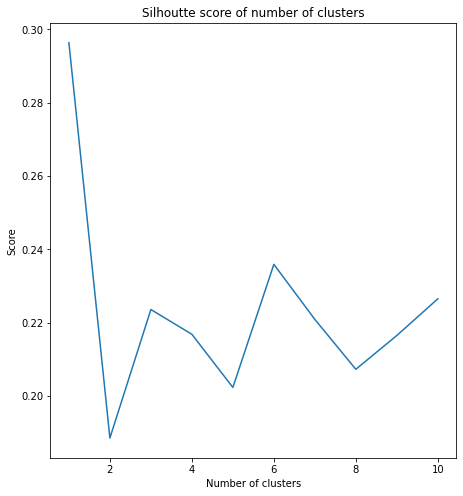

In [61]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [31]:
#clusters_bic, scores_bic = bic(df_score, 10)

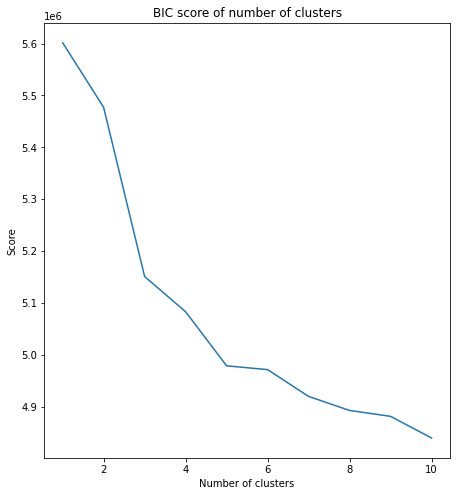

In [59]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

Here we decide to take a number of 6 clusters for our cluster analysis. The BIC score decreases, but it is not appropriate to take too much clusters, so 6 are a good choice. For the silhouette score the values are fluctuating and we can observe a peak at six clusters.

### 3.4.2 Computing Clusters with Gaussian Mixture Model

In [66]:
gm = GaussianMixture(n_components=6, random_state=42, n_init = 15).fit(df_cluster_scaled)

In [67]:
cluster = gm.predict(df_cluster_scaled)

In [68]:
cluster_prob = gm.predict_proba(df_cluster_scaled)

In [69]:
df_chicago_cluster["cluster"] = cluster

In [70]:
for k in range(6):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [71]:
df_chicago_cluster

start_time_hourly  Trip_Minutes  Trip_Miles  cluster  cluster_0_prob  \
0                        0          15.0         2.7        5    9.241915e-05   
1                        0           4.0         0.4        2    1.320698e-02   
2                        0           3.0         1.0        2    8.551338e-02   
3                        0           4.0         0.3        2    7.928040e-03   
4                        0           8.0         0.8        2    7.312054e-03   
...                    ...           ...         ...      ...             ...   
7247312                 23           3.0         0.5        3    5.465788e-02   
7247313                 23          19.0         5.1        1    9.925098e-18   
7247314                 23           9.0         1.4        0    4.581682e-01   
7247315                 23          12.0         2.0        1    1.090692e-01   
7247316                 23          11.0         3.5        1    3.037740e-09   

         cluster_1_prob  cluster_2_prob  cluster_3_prob  cluster_4_prob  \
0          3.058123e-19    1.994549e-01    5.906753e-31   3.893079e-257   
1          2.272388e-24    9.855189e-01    4.903452e-29    2.044949e-05   
2          1.063691e-25    9.128693e-01    5.616273e-32    2.112221e-40   
3          3.362586e-24    9.853811e-01    7.761108e-29    5.365695e-03   
4          2.091962e-21    9.536179e-01    5.872735e-28    8.126666e-18   
...                 ...             ...             ...             ...   
7247312    8.863715e-03    7.358218e-96    9.348431e-01    1.817717e-10   
7247313    9.669726e-01   8.885553e-100    6.378516e-10    0.000000e+00   
7247314    2.344592e-01    4.574040e-99    2.592919e-01    2.035371e-68   
7247315    7.237247e-01   1.035550e-100    1.630681e-02   6.001451e-141   
7247316    9.532567e-01    2.688685e-95    6.415001e-04    0.000000e+00   

         cluster_5_prob  
0              0.800453  
1              0.001254  
2              0.001617  
3              0.001325  
4              0.039070  
...                 ...  
7247312        0.001635  
7247313        0.033027  
7247314        0.048081  
7247315        0.150899  
7247316        0.046102  

[7247317 rows x 10 columns]

### 3.4.3 Analyzing & Labeling clusters

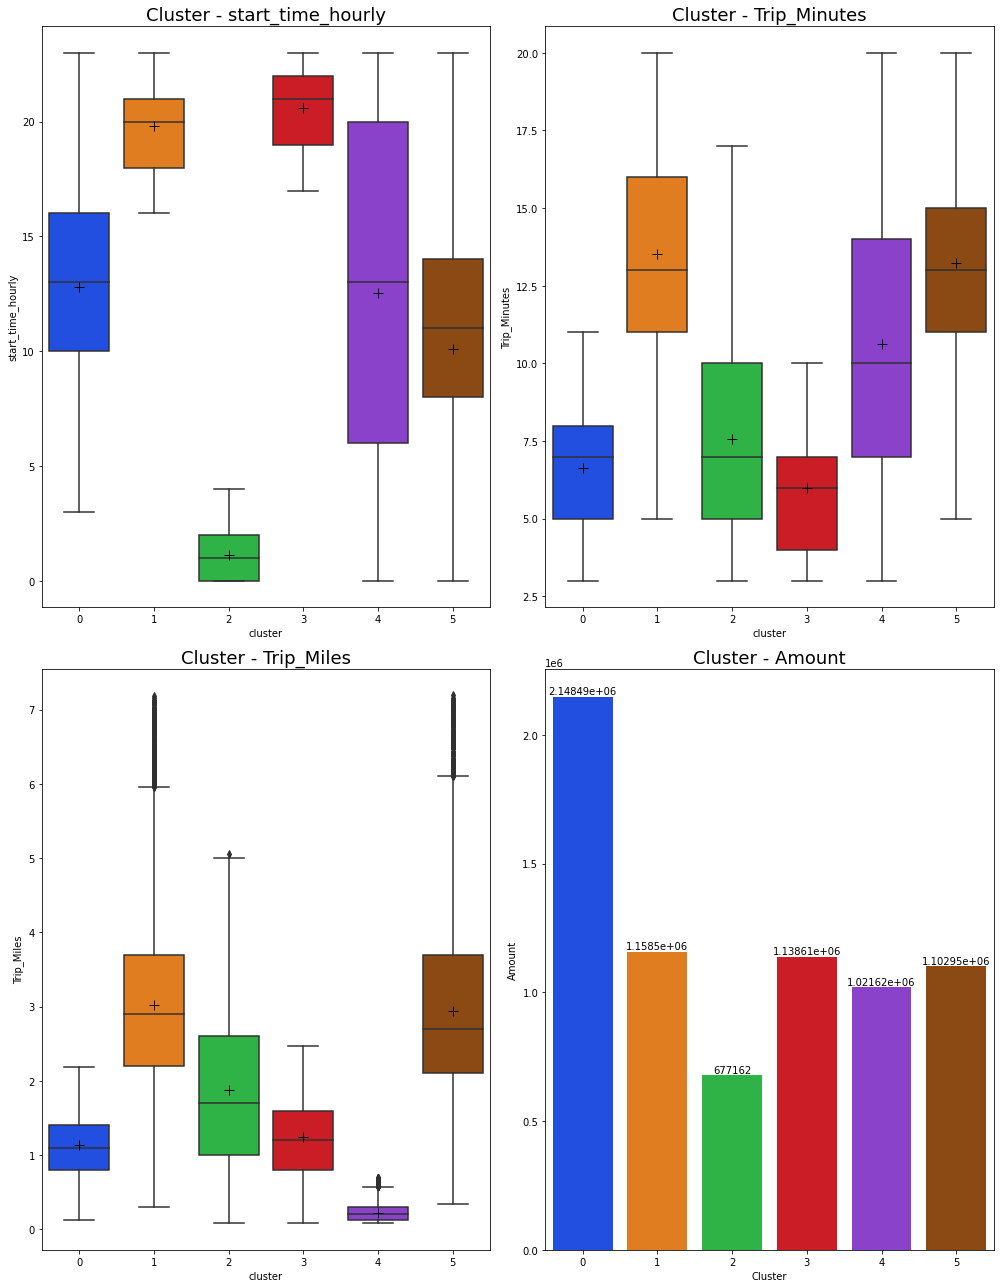

In [72]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Minutes', 'Trip_Miles'], 'cluster')

In [73]:
dfChicago_clu_combined_quantiles = get_quantiles_of_clusters(df_chicago_cluster, 6, 'cluster')
dfChicago_clu_combined_quantiles

start_time_hourly Trip_Minutes  Trip_Miles cluster_0_prob  \
Cluster                                                             
0             10.0 - 16.0    5.0 - 8.0   0.8 - 1.4    0.76 - 0.98   
1             18.0 - 21.0  11.0 - 16.0   2.2 - 3.7     0.0 - 0.01   
2               0.0 - 2.0   5.0 - 10.0   1.0 - 2.6     0.0 - 0.06   
3             19.0 - 22.0    4.0 - 7.0   0.8 - 1.6    0.04 - 0.21   
4              6.0 - 20.0   7.0 - 14.0  0.12 - 0.3      0.0 - 0.0   
5              8.0 - 14.0  11.0 - 15.0   2.1 - 3.7     0.0 - 0.06   

        cluster_1_prob cluster_2_prob cluster_3_prob cluster_4_prob  \
Cluster                                                               
0           0.0 - 0.01      0.0 - 0.0     0.0 - 0.02      0.0 - 0.0   
1          0.68 - 0.93      0.0 - 0.0     0.0 - 0.02      0.0 - 0.0   
2            0.0 - 0.0    0.85 - 0.96      0.0 - 0.0      0.0 - 0.0   
3          0.01 - 0.07      0.0 - 0.0    0.65 - 0.91      0.0 - 0.0   
4           0.0 - 0.02      0.0 - 0.0      0.0 - 0.0    0.92 - 0.98   
5           0.0 - 0.02      0.0 - 0.0      0.0 - 0.0      0.0 - 0.0   

        cluster_5_prob  Amount Trips in Cluster  Percentage  
Cluster                                                      
0          0.01 - 0.08                2148489.0       29.65  
1          0.06 - 0.19                1158496.0       15.99  
2           0.0 - 0.07                 677162.0        9.34  
3           0.0 - 0.01                1138606.0       15.71  
4          0.01 - 0.03                1021616.0       14.10  
5           0.73 - 1.0                1102948.0       15.22

In [100]:
label_names = {'0': "Short Distance - Short Duration Trips (midday)", 
               '1': "Evening Customers - Long Trips",
               '2': "Night Riders - Party People",
               '3': "Evening Customers - Short Trips", 
               '4': "Short Distance - Long Duration Trips (all day)",
               '5': "Morning (before work) Commuters",
               }

# integrating our labeled clusters in the dataframe
df_chicago_cluster['Cluster_Label'] = df_chicago_cluster['cluster'].astype(str)
df_chicago_cluster = df_chicago_cluster.replace({"Cluster_Label": label_names})

In [101]:
dfChicago_clu_index = df_chicago_cluster
dfChicago_clu_index['Trip_Index'] = df_chicago_cluster.index
dfChicago_clu_index

start_time_hourly  Trip_Minutes  Trip_Miles  cluster  cluster_0_prob  \
0                        0          15.0         2.7        5    9.241915e-05   
1                        0           4.0         0.4        2    1.320698e-02   
2                        0           3.0         1.0        2    8.551338e-02   
3                        0           4.0         0.3        2    7.928040e-03   
4                        0           8.0         0.8        2    7.312054e-03   
...                    ...           ...         ...      ...             ...   
7247312                 23           3.0         0.5        3    5.465788e-02   
7247313                 23          19.0         5.1        1    9.925098e-18   
7247314                 23           9.0         1.4        0    4.581682e-01   
7247315                 23          12.0         2.0        1    1.090692e-01   
7247316                 23          11.0         3.5        1    3.037740e-09   

         cluster_1_prob  cluster_2_prob  cluster_3_prob  cluster_4_prob  \
0          3.058123e-19    1.994549e-01    5.906753e-31   3.893079e-257   
1          2.272388e-24    9.855189e-01    4.903452e-29    2.044949e-05   
2          1.063691e-25    9.128693e-01    5.616273e-32    2.112221e-40   
3          3.362586e-24    9.853811e-01    7.761108e-29    5.365695e-03   
4          2.091962e-21    9.536179e-01    5.872735e-28    8.126666e-18   
...                 ...             ...             ...             ...   
7247312    8.863715e-03    7.358218e-96    9.348431e-01    1.817717e-10   
7247313    9.669726e-01   8.885553e-100    6.378516e-10    0.000000e+00   
7247314    2.344592e-01    4.574040e-99    2.592919e-01    2.035371e-68   
7247315    7.237247e-01   1.035550e-100    1.630681e-02   6.001451e-141   
7247316    9.532567e-01    2.688685e-95    6.415001e-04    0.000000e+00   

         cluster_5_prob                                   Cluster_Label  \
0              0.800453                 Morning (before work) Commuters   
1              0.001254                     Night Riders - Party People   
2              0.001617                     Night Riders - Party People   
3              0.001325                     Night Riders - Party People   
4              0.039070                     Night Riders - Party People   
...                 ...                                             ...   
7247312        0.001635                 Evening Customers - Short Trips   
7247313        0.033027                  Evening Customers - Long Trips   
7247314        0.048081  Short Distance - Short Duration Trips (midday)   
7247315        0.150899                  Evening Customers - Long Trips   
7247316        0.046102                  Evening Customers - Long Trips   

         Trip_Index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
7247312     7247312  
7247313     7247313  
7247314     7247314  
7247315     7247315  
7247316     7247316  

[7247317 rows x 12 columns]

### 3.4.4 Plotting the Clustering Results

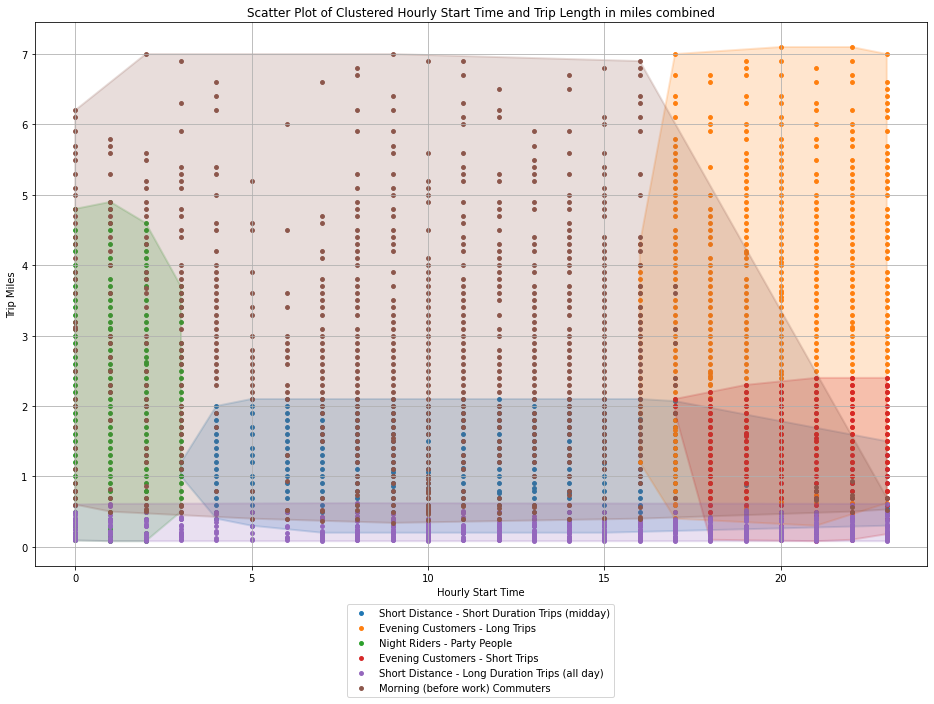

In [102]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_index.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Length in miles combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

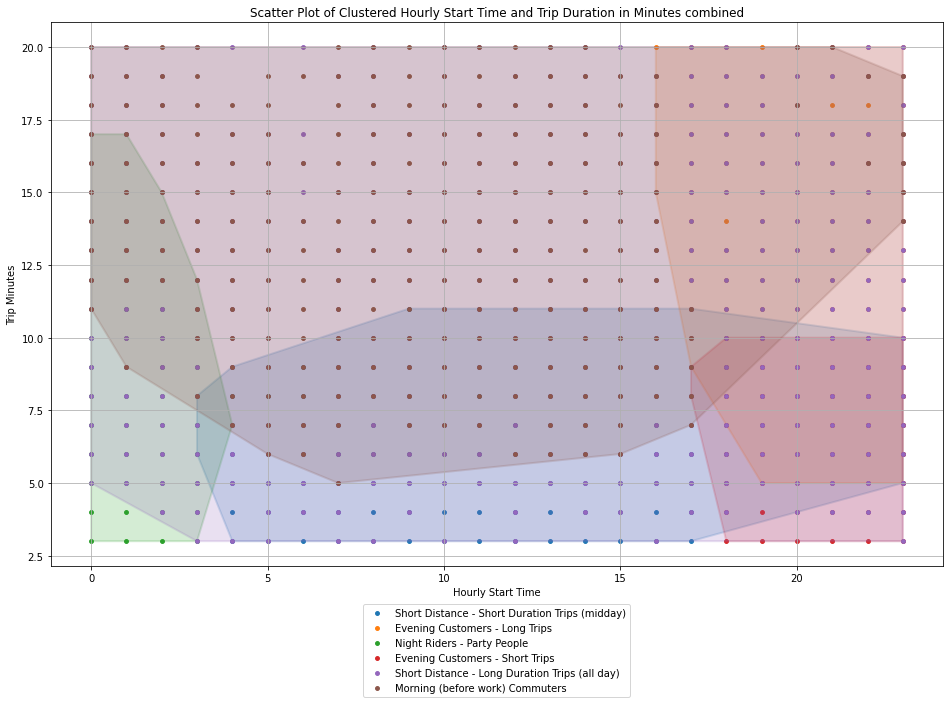

In [103]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_index.sample(n=10_000), x_col='start_time_hourly', y_col='Trip_Minutes', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Hourly Start Time', y_label="Trip Minutes", plot_title='Scatter Plot of Clustered Hourly Start Time and Trip Duration in Minutes combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

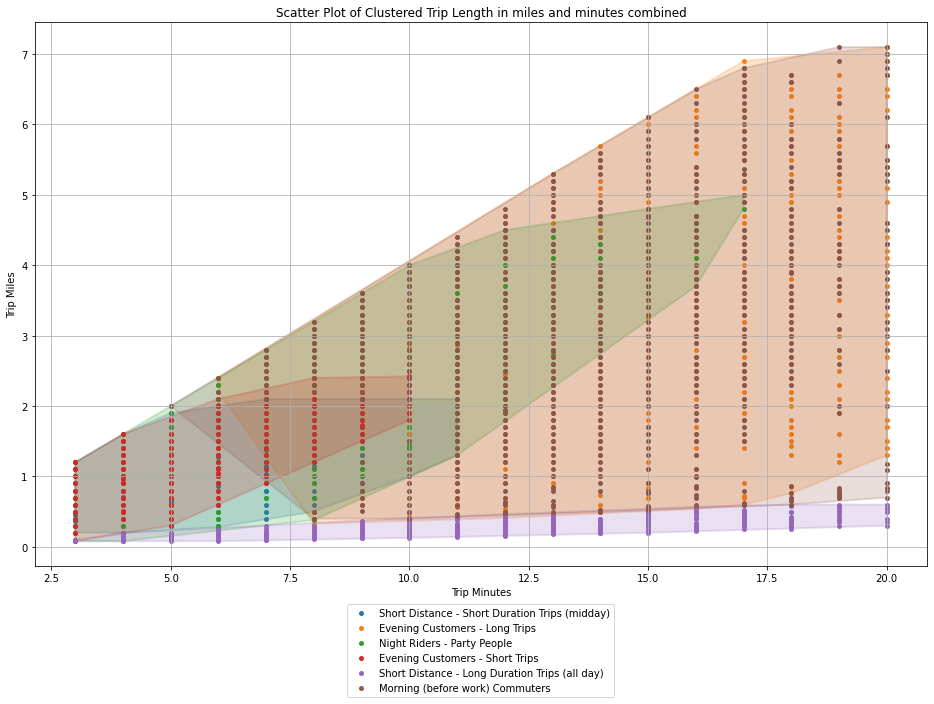

In [104]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_index.sample(n=10_000), x_col='Trip_Minutes', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Length in miles and minutes combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

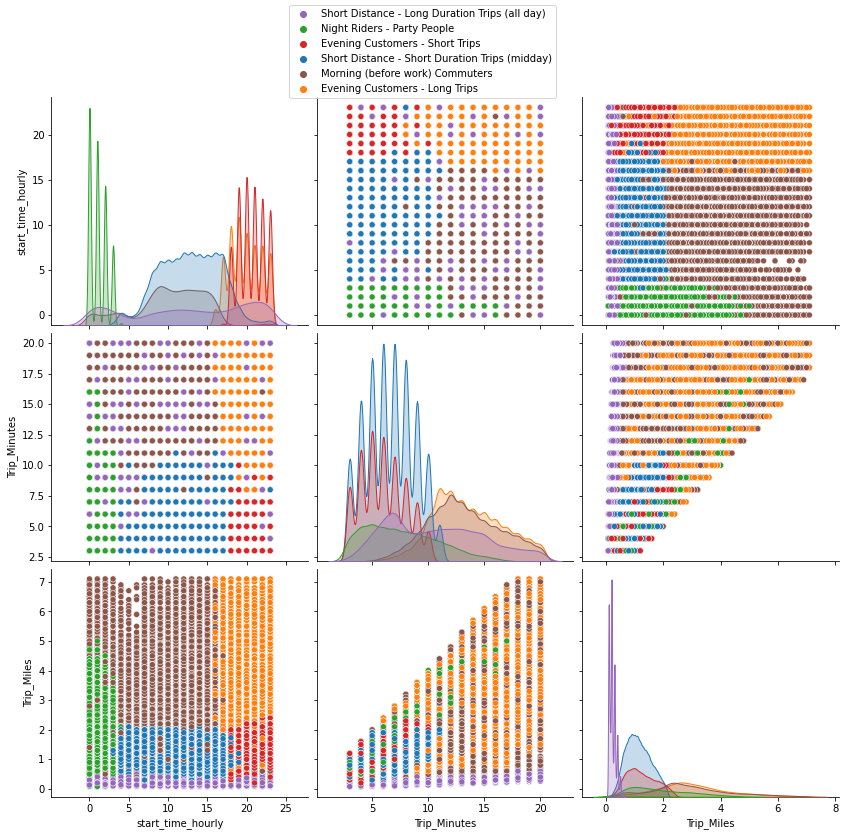

In [105]:
colors = {
          "Short Distance - Short Duration Trips (midday)" : '#1f77b4', 
            "Evening Customers - Long Trips":'#ff7f0e',
            "Night Riders - Party People": '#2ca02c',
             "Evening Customers - Short Trips": '#d62728',
          "Short Distance - Long Duration Trips (all day)": '#9467bd',
           "Morning (before work) Commuters":'#8c564b'}

g = sns.pairplot(data=dfChicago_clu_index[['start_time_hourly', 'Trip_Minutes' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

### 3.4.5 Evaluation

`Cluster 0 -` __Short Distance - Short Duration Trips (midday)__ <br>
Here we have the people who are driving short distances in a short time. These trips do not take place over the whole day, but do not have a very limited time span either. They happen from morning to afternoon, which is why we have classified them as midday.

`Cluster 1 -` __Evening Customers - Long Trips__  <br>
This cluster represent the customers who use the taxis in the evening and driving many miles needing much time (many trip minutes).

`Cluster 2 -` __Night Riders - Party People__  <br>
We observe here the customers driving at night, just as party people (as observed in chapter 3.1).

`Cluster 3 -` __Evening Customers - Short Trips__  <br>
This cluster represent the customers who use the taxis in the evening and driving only few miles and having low driving time (few trip minutes).

`Cluster 4 -` __Short Distance - Long Duration Trips (all day)__  <br>
In this cluster we observe a type of users or trips that can exist throughout the whole day. These are trips that only go over a short distance, but still have long driving times. We can imagine that these are trips that may take place in the city center, where is a lot of traffic, such that short distances need a long time.

`Cluster 5 -` __Morning (before work) Commuters__  <br>
Just as in chapter 3.1 we have here the people who are driving to work in the morning.

<hr style="border: 1px solid #8888;">

##  3.5 Fifth Cluster Analysis: `distance_to_city_center_pickup`

In [75]:
df_cluster_pickup = df_chicago[['distance_to_city_center_pickup']]

#### Scaling the data:

In [76]:
df_pickup_scaled = scaling_data(df_cluster_pickup)

### 3.5.1 Validation of Number of Clusters

In [16]:
df_score = df_pickup_scaled.sample(350000, random_state=42)
df_score

distance_to_city_center_pickup
5361192                       -0.552005
487735                         2.254290
2121174                       -0.377701
5764286                       -0.558353
1384941                       -0.924715
...                                 ...
5056243                        3.901850
8323004                        1.000371
7294291                        1.000371
7046141                       -0.588211
13188                         -0.377701

[350000 rows x 1 columns]

### Silhouette score

In [17]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

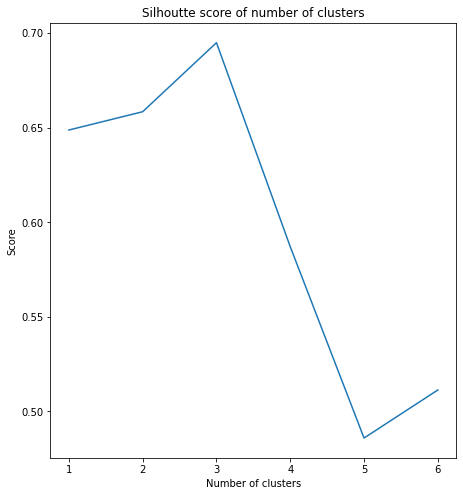

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [19]:
clusters_bic, scores_bic = bic(df_score, 6)

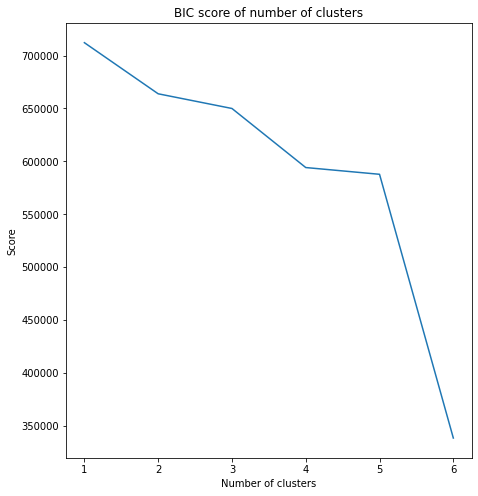

In [20]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

Because both scores show a decreasing curve, we decide to take a solution which is balanced for both. We find this solution for a number of 3 clusters.

### 3.5.2 Computing Clusters with Gaussian Mixture Model

In [77]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_pickup_scaled)

In [78]:
cluster = gm.predict(df_pickup_scaled)

In [79]:
cluster_prob = gm.predict_proba(df_pickup_scaled)

In [80]:
df_cluster_pickup["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3887589208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup["cluster"] = cluster


In [81]:
for k in range(3):
    df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3051875815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a

In [82]:
df_cluster_pickup

distance_to_city_center_pickup  cluster  cluster_0_prob  \
0                              1.614272        0    8.907030e-01   
1                              3.617721        2    5.739448e-06   
2                              2.685629        2    1.993433e-02   
3                              0.495382        0    9.878992e-01   
4                              4.526819        2    1.384896e-10   
...                                 ...      ...             ...   
7247312                        0.495382        0    9.878992e-01   
7247313                        4.435183        2    4.561298e-10   
7247314                        0.893287        0    9.830162e-01   
7247315                        0.725199        0    9.862015e-01   
7247316                        1.344327        0    9.539081e-01   

         cluster_1_prob  cluster_2_prob  
0              0.008286        0.101011  
1              0.057050        0.942944  
2              0.049946        0.930120  
3              0.002360        0.009741  
4              0.095231        0.904769  
...                 ...             ...  
7247312        0.002360        0.009741  
7247313        0.088931        0.911069  
7247314        0.002253        0.014731  
7247315        0.002143        0.011656  
7247316        0.004203        0.041889  

[7247317 rows x 5 columns]

### 3.5.3 Analyzing & Labeling clusters

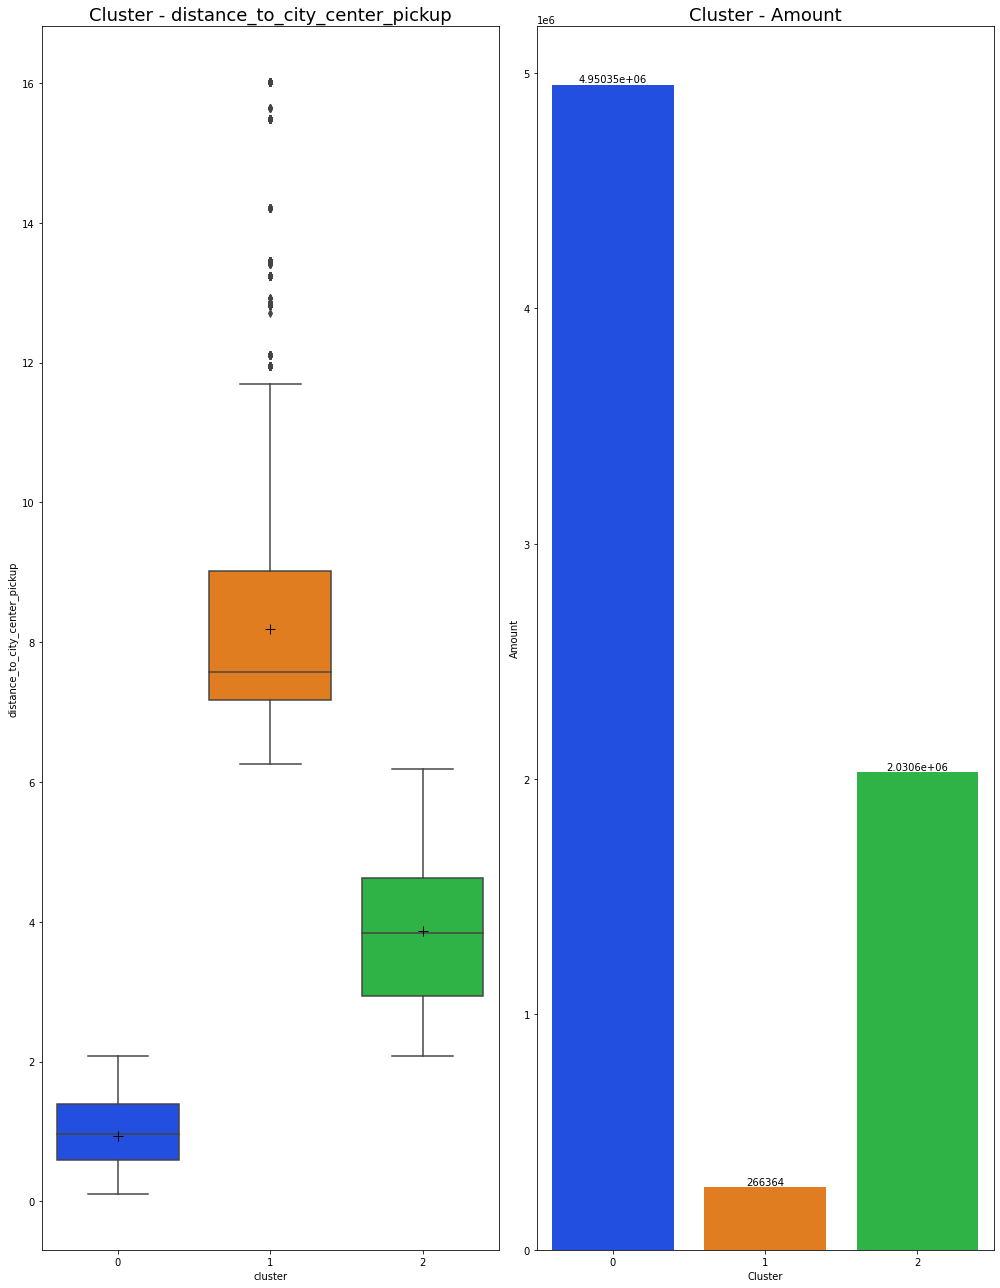

In [83]:
plot_information_about_clusters(df_cluster_pickup, ['distance_to_city_center_pickup'], 'cluster')

In [84]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_pickup, 3, 'cluster')
#dfChicago_clu_miles_time_quantiles.sort_values(by=['distance_to_city_center_pickup'], ascending=False)

In [85]:
dfChicago_clu_miles_time_quantiles

distance_to_city_center_pickup cluster_0_prob cluster_1_prob  \
Cluster                                                                
0                          0.59 - 1.39    0.95 - 0.99      0.0 - 0.0   
1                          7.18 - 9.01      0.0 - 0.0     0.86 - 1.0   
2                          2.94 - 4.62      0.0 - 0.0     0.05 - 0.1   

        cluster_2_prob  Amount Trips in Cluster  Percentage  
Cluster                                                      
0          0.01 - 0.05                4950351.0       68.31  
1           0.0 - 0.14                 266364.0        3.68  
2          0.89 - 0.94                2030602.0       28.02

In [86]:
label_names = {'0': "Close to City Center", 
               '1': "Far from City Center",
               '2': "Medium Distance from the City Center"}

# integrating our labeled clusters in the dataframe
df_cluster_pickup['Cluster_Label'] = df_cluster_pickup['cluster'].astype(str)
df_cluster_pickup = df_cluster_pickup.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_2485/3905506598.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_pickup['Cluster_Label'] = df_cluster_pickup['cluster'].astype(str)


In [87]:
dfChicago_clu_pickup_index = df_cluster_pickup
dfChicago_clu_pickup_index['Trip_Index'] = df_cluster_pickup.index
dfChicago_clu_pickup_index

distance_to_city_center_pickup  cluster  cluster_0_prob  \
0                              1.614272        0    8.907030e-01   
1                              3.617721        2    5.739448e-06   
2                              2.685629        2    1.993433e-02   
3                              0.495382        0    9.878992e-01   
4                              4.526819        2    1.384896e-10   
...                                 ...      ...             ...   
7247312                        0.495382        0    9.878992e-01   
7247313                        4.435183        2    4.561298e-10   
7247314                        0.893287        0    9.830162e-01   
7247315                        0.725199        0    9.862015e-01   
7247316                        1.344327        0    9.539081e-01   

         cluster_1_prob  cluster_2_prob                         Cluster_Label  \
0              0.008286        0.101011                  Close to City Center   
1              0.057050        0.942944  Medium Distance from the City Center   
2              0.049946        0.930120  Medium Distance from the City Center   
3              0.002360        0.009741                  Close to City Center   
4              0.095231        0.904769  Medium Distance from the City Center   
...                 ...             ...                                   ...   
7247312        0.002360        0.009741                  Close to City Center   
7247313        0.088931        0.911069  Medium Distance from the City Center   
7247314        0.002253        0.014731                  Close to City Center   
7247315        0.002143        0.011656                  Close to City Center   
7247316        0.004203        0.041889                  Close to City Center   

         Trip_Index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
7247312     7247312  
7247313     7247313  
7247314     7247314  
7247315     7247315  
7247316     7247316  

[7247317 rows x 7 columns]

### 3.5.4 Plotting the Clustering Results

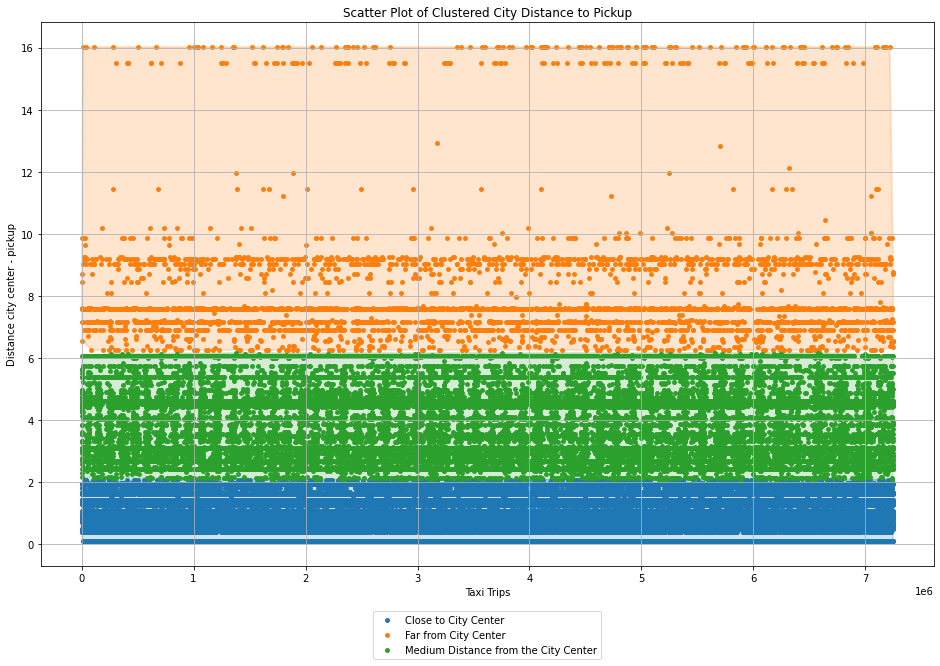

In [88]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_pickup_index.sample(n=100000), x_col='Trip_Index', y_col='distance_to_city_center_pickup', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered City Distance to Pickup', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.5.5 Displaying Results on a Map of Chicago

In [89]:
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.DataFrame(dfChicago_clu_pickup_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_pickup_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_pickup_hex_ids, 
                                                                df_chicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_pickup_hex_ids

distance_to_city_center_pickup  cluster  cluster_0_prob  \
0                              1.614272        0    8.907030e-01   
1                              3.617721        2    5.739448e-06   
2                              2.685629        2    1.993433e-02   
3                              0.495382        0    9.878992e-01   
4                              4.526819        2    1.384896e-10   
...                                 ...      ...             ...   
7247312                        0.495382        0    9.878992e-01   
7247313                        4.435183        2    4.561298e-10   
7247314                        0.893287        0    9.830162e-01   
7247315                        0.725199        0    9.862015e-01   
7247316                        1.344327        0    9.539081e-01   

         cluster_1_prob  cluster_2_prob                         Cluster_Label  \
0              0.008286        0.101011                  Close to City Center   
1              0.057050        0.942944  Medium Distance from the City Center   
2              0.049946        0.930120  Medium Distance from the City Center   
3              0.002360        0.009741                  Close to City Center   
4              0.095231        0.904769  Medium Distance from the City Center   
...                 ...             ...                                   ...   
7247312        0.002360        0.009741                  Close to City Center   
7247313        0.088931        0.911069  Medium Distance from the City Center   
7247314        0.002253        0.014731                  Close to City Center   
7247315        0.002143        0.011656                  Close to City Center   
7247316        0.004203        0.041889                  Close to City Center   

         Trip_Index h3_hex_id_high_res h3_hex_id_medium_res h3_hex_id_low_res  
0                 0    882664ca91fffff      872664ca9ffffff   862664cafffffff  
1                 1    882664c12bfffff      872664c12ffffff   862664c17ffffff  
2                 2    882664cac3fffff      872664cacffffff   862664cafffffff  
3                 3    882664c1adfffff      872664c1affffff   862664c1fffffff  
4                 4    882664ca11fffff      872664ca1ffffff   862664ca7ffffff  
...             ...                ...                  ...               ...  
7247312     7247312    882664c1adfffff      872664c1affffff   862664c1fffffff  
7247313     7247313    882664c10dfffff      872664c10ffffff   862664c17ffffff  
7247314     7247314    882664c1e1fffff      872664c1effffff   862664c1fffffff  
7247315     7247315    882664c1e3fffff      872664c1effffff   862664c1fffffff  
7247316     7247316    882664c1ebfffff      872664c1effffff   862664c1fffffff  

[7247317 rows x 10 columns]

In [96]:
# create lists of hex ids for each cluster
hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 0, 'h3_hex_id_high_res')
hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 1, 'h3_hex_id_high_res')
hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_pickup_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_2, color='#2ca02c') 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_1, color='#ff7f0e', folium_map=m_hex_high_pickup_distance_city_center) 
m_hex_high_pickup_distance_city_center = visualize_hexagons(hex_ids_for_cluster_0, color='#1f77b4', folium_map=m_hex_high_pickup_distance_city_center)
display(m_hex_high_pickup_distance_city_center)

We here see the different clusters we observed on a map of chicago. As you can see on the map, the orange cluster are the ones far away, the green color shows the medium far away cluster and the blue hexagons are near city center cluster.

### 3.5.6 Evaluation

`Cluster 0 -` __Close to City Center__ <br>
Trips that start close to the city center.

`Cluster 1 -` __Far from City Center__  <br>
This cluster represent the trips with a pickup area far away.

`Cluster 2 -` __Medium Distance from the City Center__  <br>
We observe here the trips with medium distance from city center.

<hr style="border: 1px solid #8888;">

##  3.6 Sixth Cluster Analysis: `distance_to_city_center_dropoff`

In [20]:
df_cluster_dropoff = df_chicago[['distance_to_city_center_dropoff']]

#### Scaling the data:

In [21]:
df_dropoff_scaled = scaling_data(df_cluster_dropoff)

### 3.6.1 Validation of Number of Clusters

In [53]:
df_score = df_dropoff_scaled.sample(350000, random_state=42)
df_score

distance_to_city_center_dropoff
5361192                        -0.671081
487735                          1.490856
2121174                         2.136684
5764286                        -0.696972
1384941                        -0.775683
...                                  ...
5056243                         0.844338
8323004                        -0.370384
7294291                         2.716103
7046141                        -0.775683
13188                           0.884998

[350000 rows x 1 columns]

### Silhouette score

In [54]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

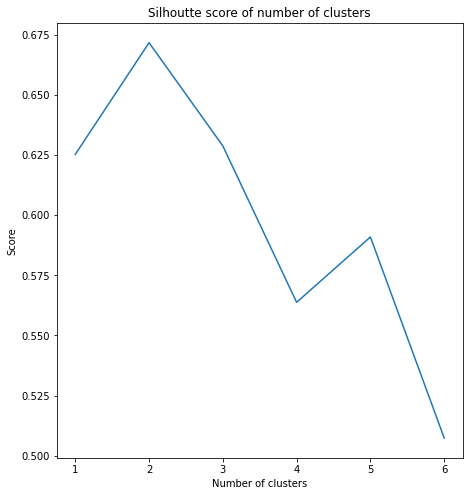

In [55]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [56]:
clusters_bic, scores_bic = bic(df_score, 6)

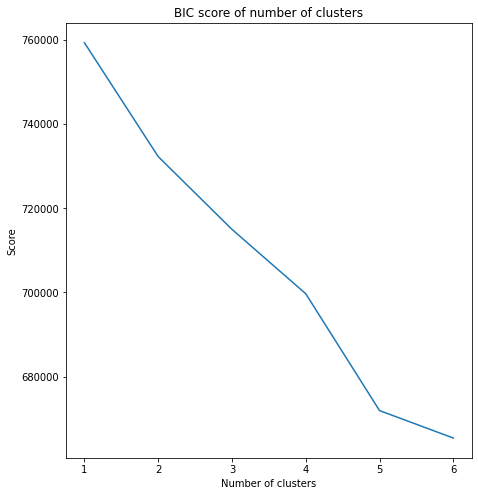

In [57]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

Here we take three clusters to perform the analysis on. Because: For silhouette score the score for three is right before a relatively strong drop and the BIC score is a nearly linear decreasing curve. 

### 3.6.2 Computing Clusters with Gaussian Mixture Model

In [22]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_dropoff_scaled)

In [23]:
cluster = gm.predict(df_dropoff_scaled)

In [24]:
cluster_prob = gm.predict_proba(df_dropoff_scaled)

In [25]:
df_cluster_dropoff["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_1603/1189943988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff["cluster"] = cluster


In [26]:
for k in range(3):
    df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_1603/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_1603/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_1603/2649727858.py:2: SettingWithCopyWarning: 
A value is trying to be set on

In [27]:
df_cluster_dropoff

distance_to_city_center_dropoff  cluster  cluster_0_prob  \
0                               1.387700        0    9.364723e-01   
1                               3.548918        2    3.001594e-05   
2                               2.685629        2    2.837521e-02   
3                               0.587129        0    9.826261e-01   
4                               4.526819        2    8.646412e-10   
...                                  ...      ...             ...   
7247312                         0.495382        0    9.831214e-01   
7247313                         7.088074        1    3.799751e-28   
7247314                         1.959038        0    6.368720e-01   
7247315                         1.609951        0    8.783804e-01   
7247316                         2.141079        2    4.210048e-01   

         cluster_1_prob  cluster_2_prob  
0              0.004798        0.058729  
1              0.062207        0.937763  
2              0.050658        0.920967  
3              0.002350        0.015023  
4              0.112433        0.887567  
...                 ...             ...  
7247312        0.002476        0.014403  
7247313        0.860187        0.139813  
7247314        0.021231        0.341897  
7247315        0.008176        0.113444  
7247316        0.032161        0.546834  

[7247317 rows x 5 columns]

### 3.6.3 Analyzing & Labeling clusters

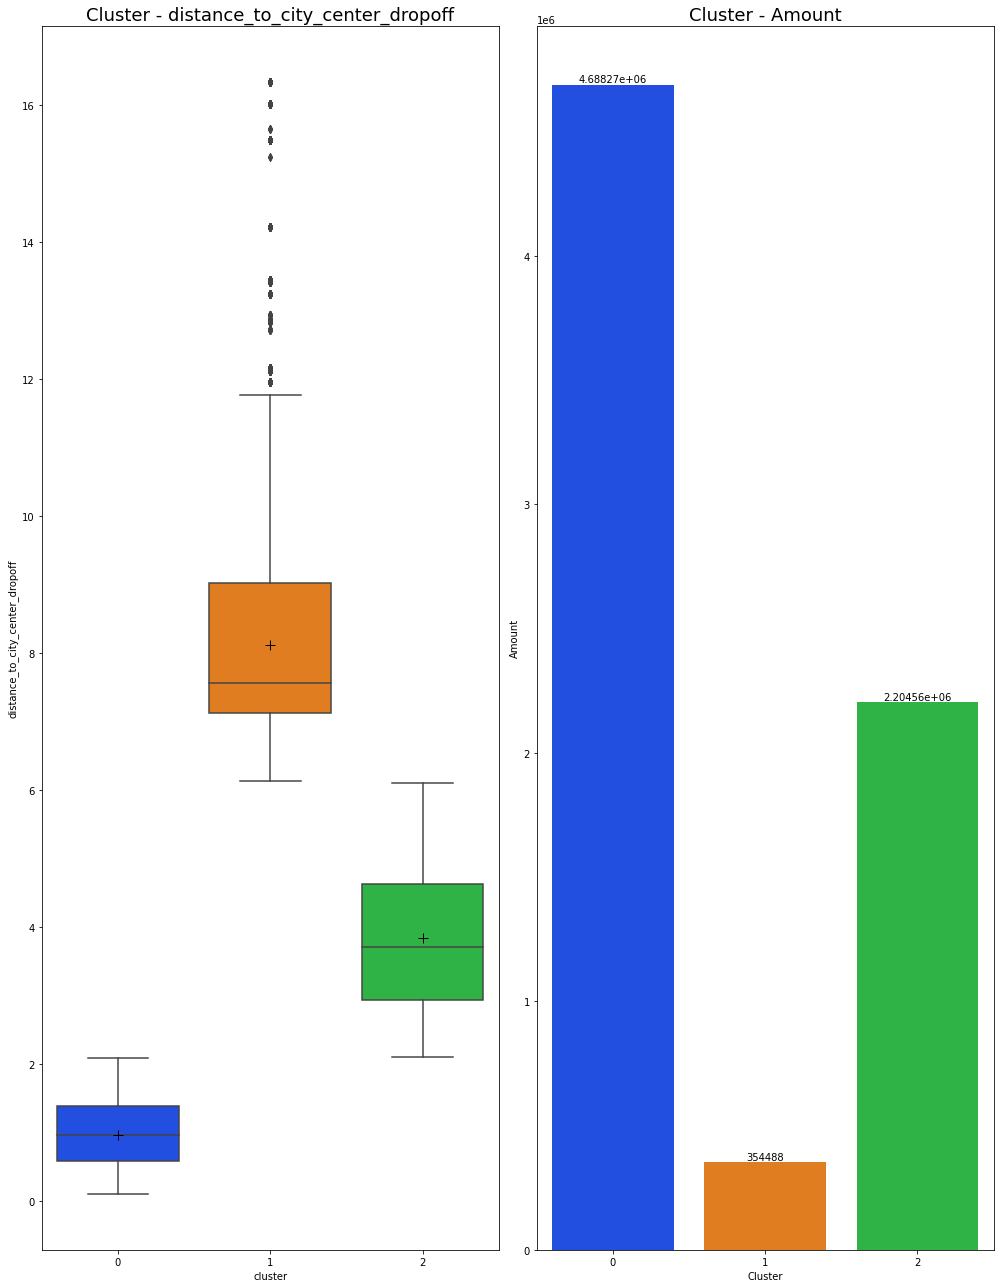

In [28]:
plot_information_about_clusters(df_cluster_dropoff, ['distance_to_city_center_dropoff'], 'cluster')

In [29]:
dfChicago_clu_miles_time_quantiles = get_quantiles_of_clusters(df_cluster_dropoff, 3, 'cluster')
dfChicago_clu_miles_time_quantiles

distance_to_city_center_dropoff cluster_0_prob cluster_1_prob  \
Cluster                                                                 
0                           0.59 - 1.39    0.94 - 0.98      0.0 - 0.0   
1                           7.12 - 9.01      0.0 - 0.0     0.87 - 1.0   
2                           2.94 - 4.62      0.0 - 0.0    0.05 - 0.12   

        cluster_2_prob  Amount Trips in Cluster  Percentage  
Cluster                                                      
0          0.02 - 0.06                4688271.0       64.69  
1           0.0 - 0.13                 354488.0        4.89  
2          0.87 - 0.94                2204558.0       30.42

In [30]:
label_names = {'0': "Close to City Center", 
               '1': "Far from City Center",
               '2': "Medium Distance from the City Center"}

# integrating our labeled clusters in the dataframe
df_cluster_dropoff['Cluster_Label'] = df_cluster_dropoff['cluster'].astype(str)
df_cluster_dropoff = df_cluster_dropoff.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_1603/2302000845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_dropoff['Cluster_Label'] = df_cluster_dropoff['cluster'].astype(str)


In [31]:
dfChicago_clu_dropoff_index = df_cluster_dropoff
dfChicago_clu_dropoff_index['Trip_Index'] = df_cluster_dropoff.index
dfChicago_clu_dropoff_index

distance_to_city_center_dropoff  cluster  cluster_0_prob  \
0                               1.387700        0    9.364723e-01   
1                               3.548918        2    3.001594e-05   
2                               2.685629        2    2.837521e-02   
3                               0.587129        0    9.826261e-01   
4                               4.526819        2    8.646412e-10   
...                                  ...      ...             ...   
7247312                         0.495382        0    9.831214e-01   
7247313                         7.088074        1    3.799751e-28   
7247314                         1.959038        0    6.368720e-01   
7247315                         1.609951        0    8.783804e-01   
7247316                         2.141079        2    4.210048e-01   

         cluster_1_prob  cluster_2_prob                         Cluster_Label  \
0              0.004798        0.058729                  Close to City Center   
1              0.062207        0.937763  Medium Distance from the City Center   
2              0.050658        0.920967  Medium Distance from the City Center   
3              0.002350        0.015023                  Close to City Center   
4              0.112433        0.887567  Medium Distance from the City Center   
...                 ...             ...                                   ...   
7247312        0.002476        0.014403                  Close to City Center   
7247313        0.860187        0.139813                  Far from City Center   
7247314        0.021231        0.341897                  Close to City Center   
7247315        0.008176        0.113444                  Close to City Center   
7247316        0.032161        0.546834  Medium Distance from the City Center   

         Trip_Index  
0                 0  
1                 1  
2                 2  
3                 3  
4                 4  
...             ...  
7247312     7247312  
7247313     7247313  
7247314     7247314  
7247315     7247315  
7247316     7247316  

[7247317 rows x 7 columns]

### 3.6.4 Plotting the Clustering Results

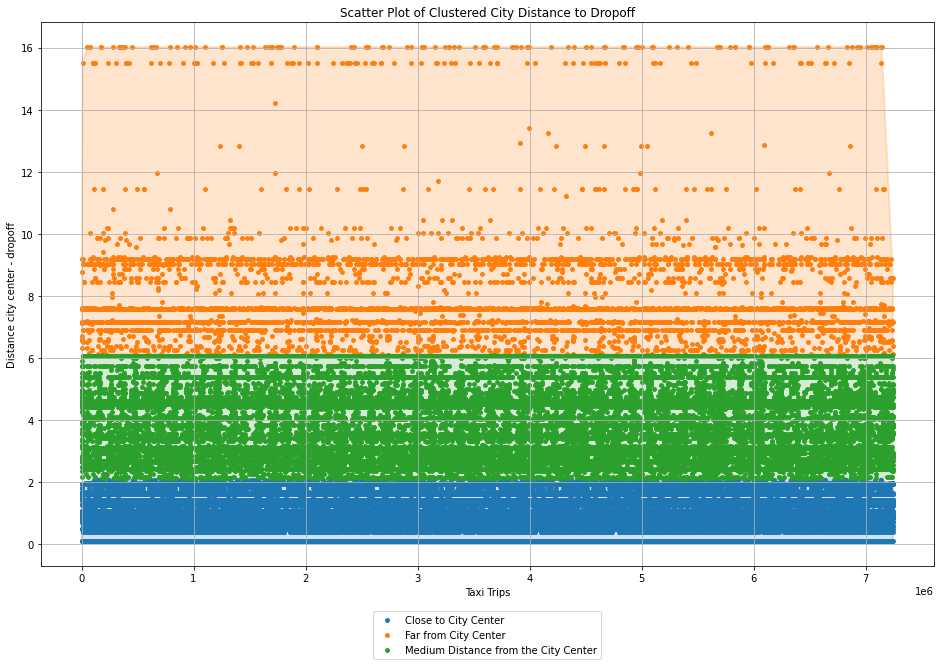

In [32]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(dfChicago_clu_dropoff_index.sample(n=100000), x_col='Trip_Index', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Taxi Trips', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered City Distance to Dropoff', leg_loc='lower center', anchor=(0.5, -0.18))

### 3.6.5 Displaying Results on a Map of Chicago

In [33]:
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.DataFrame(dfChicago_clu_dropoff_index)

# Append the columns for the hexagon ids to clustered dataframe of distance to city center
dfChicago_clu_distance_to_city_center_dropoff_hex_ids = pd.concat([dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 
                                                                df_chicago[['h3_hex_id_high_res', 'h3_hex_id_medium_res', 'h3_hex_id_low_res']]], axis=1)

dfChicago_clu_distance_to_city_center_dropoff_hex_ids

distance_to_city_center_dropoff  cluster  cluster_0_prob  \
0                               1.387700        0    9.364723e-01   
1                               3.548918        2    3.001594e-05   
2                               2.685629        2    2.837521e-02   
3                               0.587129        0    9.826261e-01   
4                               4.526819        2    8.646412e-10   
...                                  ...      ...             ...   
7247312                         0.495382        0    9.831214e-01   
7247313                         7.088074        1    3.799751e-28   
7247314                         1.959038        0    6.368720e-01   
7247315                         1.609951        0    8.783804e-01   
7247316                         2.141079        2    4.210048e-01   

         cluster_1_prob  cluster_2_prob                         Cluster_Label  \
0              0.004798        0.058729                  Close to City Center   
1              0.062207        0.937763  Medium Distance from the City Center   
2              0.050658        0.920967  Medium Distance from the City Center   
3              0.002350        0.015023                  Close to City Center   
4              0.112433        0.887567  Medium Distance from the City Center   
...                 ...             ...                                   ...   
7247312        0.002476        0.014403                  Close to City Center   
7247313        0.860187        0.139813                  Far from City Center   
7247314        0.021231        0.341897                  Close to City Center   
7247315        0.008176        0.113444                  Close to City Center   
7247316        0.032161        0.546834  Medium Distance from the City Center   

         Trip_Index h3_hex_id_high_res h3_hex_id_medium_res h3_hex_id_low_res  
0                 0    882664ca91fffff      872664ca9ffffff   862664cafffffff  
1                 1    882664c12bfffff      872664c12ffffff   862664c17ffffff  
2                 2    882664cac3fffff      872664cacffffff   862664cafffffff  
3                 3    882664c1adfffff      872664c1affffff   862664c1fffffff  
4                 4    882664ca11fffff      872664ca1ffffff   862664ca7ffffff  
...             ...                ...                  ...               ...  
7247312     7247312    882664c1adfffff      872664c1affffff   862664c1fffffff  
7247313     7247313    882664c10dfffff      872664c10ffffff   862664c17ffffff  
7247314     7247314    882664c1e1fffff      872664c1effffff   862664c1fffffff  
7247315     7247315    882664c1e3fffff      872664c1effffff   862664c1fffffff  
7247316     7247316    882664c1ebfffff      872664c1effffff   862664c1fffffff  

[7247317 rows x 10 columns]

In [37]:
# create lists of hex ids for each cluster
dropoff_hex_ids_for_cluster_0 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 0, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_1 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 1, 'h3_hex_id_high_res')
dropoff_hex_ids_for_cluster_2 = get_hex_ids_for_cluster_and_resolution(dfChicago_clu_distance_to_city_center_dropoff_hex_ids, 2, 'h3_hex_id_high_res')

# Generate Map with high resolution hexagons for pickup distance to city center clusters
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_0, color='#ff7f0e') 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_2, color='#2ca02c', folium_map=m_hex_high_dropoff_distance_city_center) 
m_hex_high_dropoff_distance_city_center = visualize_hexagons(dropoff_hex_ids_for_cluster_1, color='#1f77b4', folium_map=m_hex_high_dropoff_distance_city_center)
display(m_hex_high_dropoff_distance_city_center)

Mapping the clusters on the city map if Chicago: seeing blue clusters, that are near to the city center, green representing medium distance and the orange ones, which are ar away. Here the soft clustering does not seem to cluster very well, since the clusters are not precisely represented and overlap much.

### 3.6.6 Evaluation

`Cluster 0 -` __Close to City Center__ <br>
Trips that end close to the city center.

`Cluster 1 -` __Far from City Center__  <br>
This cluster represent the trips with a dropoff area far away.

`Cluster 2 -` __Medium Distance from the City Center__  <br>
We observe here the trips with medium distance from city center.

<hr style="border: 1px solid #8888;">

##  3.7 Seventh Cluster Analysis: `distance_to_city_center_dropoff`, `distance_to_city_center_pickup`, `Trip_Minutes` and `Trip_Miles`

In [20]:
df_chicago_location = df_chicago[['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles",'Trip_Minutes']]

#### Scaling the data:

In [21]:
df_location_scaled = scaling_data(df_chicago_location)

In [22]:
df_location_scaled

distance_to_city_center_pickup  distance_to_city_center_dropoff  \
0                             -0.211553                        -0.389883   
1                              0.815253                         0.660510   
2                              0.337538                         0.240935   
3                             -0.785005                        -0.778976   
4                              1.281183                         1.135788   
...                                 ...                              ...   
7247312                       -0.785005                        -0.823566   
7247313                        1.234218                         2.380606   
7247314                       -0.581071                        -0.112202   
7247315                       -0.667220                        -0.281865   
7247316                       -0.349905                        -0.023727   

         Trip_Miles  Trip_Minutes  
0          0.787302      1.343110  
1         -0.970516     -1.242093  
2         -0.511955     -1.477111  
3         -1.046943     -1.242093  
4         -0.664808     -0.302019  
...             ...           ...  
7247312   -0.894089     -1.477111  
7247313    2.621546      2.283184  
7247314   -0.206247     -0.067001  
7247315    0.252314      0.638055  
7247316    1.398717      0.403036  

[7247317 rows x 4 columns]

### 3.7.1 Validation of Number of Clusters

In [122]:
df_score = df_location_scaled.sample(750000, random_state=42)
df_score

distance_to_city_center_pickup  distance_to_city_center_dropoff  \
6337986                        0.531277                         1.240208   
1276690                       -0.785005                         1.507590   
1248107                       -0.581071                        -1.014293   
6948608                        0.663752                         0.317574   
1253462                       -0.320689                        -0.383258   
...                                 ...                              ...   
4111997                       -0.709613                        -0.098104   
1387658                       -0.368851                        -0.752072   
6276294                       -0.594371                        -0.588849   
3769332                       -0.327675                         1.183171   
3739910                       -0.785005                        -1.014293   

         Trip_Miles  
6337986   -1.123370  
1276690   -1.046943  
1248107   -0.511955  
6948608   -1.215082  
1253462   -0.817662  
...             ...  
4111997   -0.129820  
1387658   -0.741235  
6276294   -0.664808  
3769332   -1.123370  
3739910   -0.817662  

[750000 rows x 3 columns]

### Silhouette score

In [123]:
clusters_sil, scores_sil = silhoutte(df_score, 10)

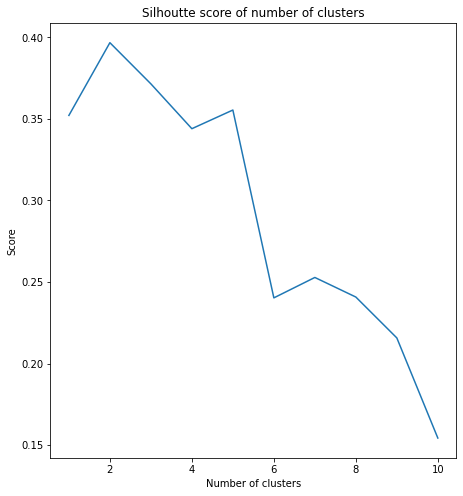

In [124]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [125]:
clusters_bic, scores_bic = bic(df_score, 10)

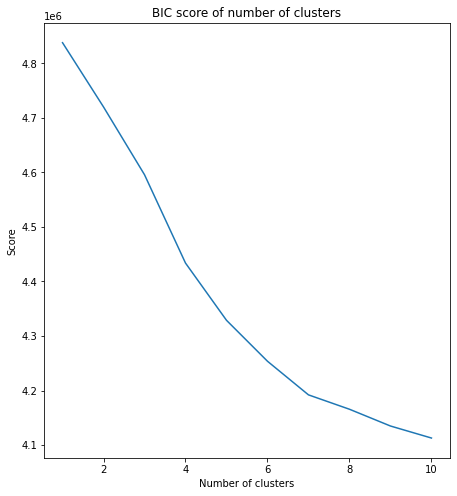

In [126]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

Here we decide for five clusters as an appropriate number, because at this value we have a high value in silhouette score (before a strong decrease) and because the BIC score is a decreasing line. For more clusters the silhoutte score is worse.

### 3.7.2 Computing Clusters with Gaussian Mixture Model

In [23]:
gm = GaussianMixture(n_components=5, random_state=42, n_init = 15).fit(df_location_scaled)

In [24]:
cluster = gm.predict(df_location_scaled)

In [25]:
cluster_prob = gm.predict_proba(df_location_scaled)

In [26]:
df_chicago_location["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_37329/756615451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_location["cluster"] = cluster


In [27]:
for k in range(5):
    df_chicago_location[f"cluster_{k}_prob"] = cluster_prob[:, k]

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_37329/2725407020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_location[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_37329/2725407020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_location[f"cluster_{k}_prob"] = cluster_prob[:, k]
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_37329/2725407020.py:2: SettingWithCopyWarning: 
A value is trying to be s

In [28]:
df_chicago_location

distance_to_city_center_pickup  distance_to_city_center_dropoff  \
0                              1.614272                         1.387700   
1                              3.617721                         3.548918   
2                              2.685629                         2.685629   
3                              0.495382                         0.587129   
4                              4.526819                         4.526819   
...                                 ...                              ...   
7247312                        0.495382                         0.495382   
7247313                        4.435183                         7.088074   
7247314                        0.893287                         1.959038   
7247315                        0.725199                         1.609951   
7247316                        1.344327                         2.141079   

         Trip_Miles  Trip_Minutes  cluster  cluster_0_prob  cluster_1_prob  \
0               2.7          15.0        1   3.698648e-181    9.758455e-01   
1               0.4           4.0        2    8.126605e-04    1.011169e-12   
2               1.0           3.0        2    1.790482e-28    3.840003e-05   
3               0.3           4.0        3    4.029064e-04    4.322904e-03   
4               0.8           8.0        2    2.118485e-11    3.014623e-19   
...             ...           ...      ...             ...             ...   
7247312         0.5           3.0        3    3.758650e-09    2.775941e-03   
7247313         5.1          19.0        4    0.000000e+00    6.494468e-18   
7247314         1.4           9.0        3    1.487388e-47    3.911038e-01   
7247315         2.0          12.0        1    3.772663e-98    9.327588e-01   
7247316         3.5          11.0        1    0.000000e+00    9.383493e-01   

         cluster_2_prob  cluster_3_prob  cluster_4_prob  
0              0.000227    2.115448e-04        0.023715  
1              0.997557    8.851953e-13        0.001630  
2              0.999121    5.281609e-05        0.000787  
3              0.007296    9.879722e-01        0.000006  
4              0.838489    4.930343e-23        0.161511  
...                 ...             ...             ...  
7247312        0.011892    9.853289e-01        0.000003  
7247313        0.000004    9.582922e-57        0.999996  
7247314        0.037871    5.672649e-01        0.003760  
7247315        0.002623    5.810572e-02        0.006512  
7247316        0.007277    3.563176e-08        0.054374  

[7247317 rows x 10 columns]

### 3.7.3 Analyzing & Labeling clusters

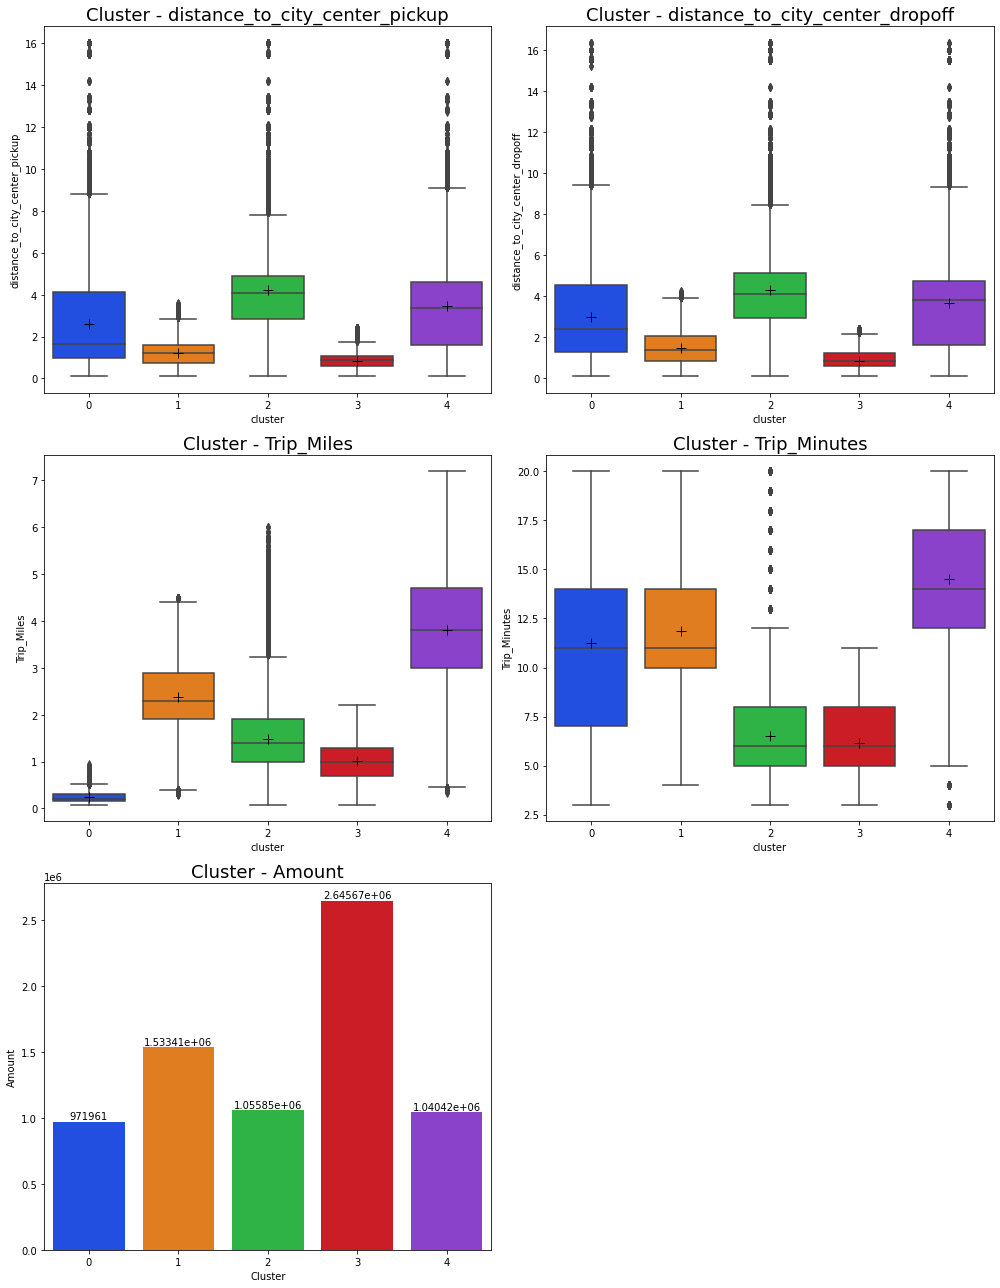

In [29]:
plot_information_about_clusters(df_chicago_location,
     ['distance_to_city_center_pickup','distance_to_city_center_dropoff',"Trip_Miles","Trip_Minutes"], 'cluster')

In [30]:
dfChicago_clu_location_quantiles = get_quantiles_of_clusters(df_chicago_location, 5, 'cluster')
dfChicago_clu_location_quantiles

distance_to_city_center_pickup distance_to_city_center_dropoff  \
Cluster                                                                  
0                          0.96 - 4.12                     1.27 - 4.53   
1                          0.73 - 1.61                     0.83 - 2.07   
2                          2.84 - 4.89                     2.94 - 5.15   
3                          0.59 - 1.07                     0.59 - 1.23   
4                          1.61 - 4.62                     1.61 - 4.74   

         Trip_Miles Trip_Minutes cluster_0_prob cluster_1_prob cluster_2_prob  \
Cluster                                                                         
0        0.15 - 0.3   7.0 - 14.0     0.95 - 1.0      0.0 - 0.0      0.0 - 0.0   
1         1.9 - 2.9  10.0 - 14.0      0.0 - 0.0    0.72 - 0.95     0.0 - 0.06   
2         1.0 - 1.9    5.0 - 8.0      0.0 - 0.0      0.0 - 0.0     0.88 - 1.0   
3         0.7 - 1.3    5.0 - 8.0      0.0 - 0.0    0.01 - 0.08    0.01 - 0.03   
4         3.0 - 4.7  12.0 - 17.0      0.0 - 0.0     0.0 - 0.03     0.0 - 0.01   

        cluster_3_prob cluster_4_prob  Amount Trips in Cluster  Percentage  
Cluster                                                                     
0            0.0 - 0.0     0.0 - 0.01                 971961.0       13.41  
1           0.0 - 0.08    0.01 - 0.07                1533412.0       21.16  
2            0.0 - 0.0     0.0 - 0.05                1055851.0       14.57  
3          0.85 - 0.98      0.0 - 0.0                2645674.0       36.51  
4            0.0 - 0.0     0.86 - 1.0                1040419.0       14.36

In [31]:
label_names = {'0': "Medium Distance from the City Center - Medium Trip Customers", 
               '1': "Close to City Center - Long Trip Customers",
               '2': "Far from City Center - Short Trip Customers",
              '3': "Close to City Center - Short Trip Customers",
               '4': "Far from City Center - Long Trip Customers"}

# integrating our labeled clusters in the dataframe
df_chicago_location['Cluster_Label'] = df_chicago_location['cluster'].astype(str)
df_chicago_location = df_chicago_location.replace({"Cluster_Label": label_names})

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_37329/2519564890.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_location['Cluster_Label'] = df_chicago_location['cluster'].astype(str)


In [32]:
dfChicago_clu_dropoff_index = df_chicago_location
dfChicago_clu_dropoff_index['Trip_Index'] = df_chicago_location.index
dfChicago_clu_dropoff_index

distance_to_city_center_pickup  distance_to_city_center_dropoff  \
0                              1.614272                         1.387700   
1                              3.617721                         3.548918   
2                              2.685629                         2.685629   
3                              0.495382                         0.587129   
4                              4.526819                         4.526819   
...                                 ...                              ...   
7247312                        0.495382                         0.495382   
7247313                        4.435183                         7.088074   
7247314                        0.893287                         1.959038   
7247315                        0.725199                         1.609951   
7247316                        1.344327                         2.141079   

         Trip_Miles  Trip_Minutes  cluster  cluster_0_prob  cluster_1_prob  \
0               2.7          15.0        1   3.698648e-181    9.758455e-01   
1               0.4           4.0        2    8.126605e-04    1.011169e-12   
2               1.0           3.0        2    1.790482e-28    3.840003e-05   
3               0.3           4.0        3    4.029064e-04    4.322904e-03   
4               0.8           8.0        2    2.118485e-11    3.014623e-19   
...             ...           ...      ...             ...             ...   
7247312         0.5           3.0        3    3.758650e-09    2.775941e-03   
7247313         5.1          19.0        4    0.000000e+00    6.494468e-18   
7247314         1.4           9.0        3    1.487388e-47    3.911038e-01   
7247315         2.0          12.0        1    3.772663e-98    9.327588e-01   
7247316         3.5          11.0        1    0.000000e+00    9.383493e-01   

         cluster_2_prob  cluster_3_prob  cluster_4_prob  \
0              0.000227    2.115448e-04        0.023715   
1              0.997557    8.851953e-13        0.001630   
2              0.999121    5.281609e-05        0.000787   
3              0.007296    9.879722e-01        0.000006   
4              0.838489    4.930343e-23        0.161511   
...                 ...             ...             ...   
7247312        0.011892    9.853289e-01        0.000003   
7247313        0.000004    9.582922e-57        0.999996   
7247314        0.037871    5.672649e-01        0.003760   
7247315        0.002623    5.810572e-02        0.006512   
7247316        0.007277    3.563176e-08        0.054374   

                                       Cluster_Label  Trip_Index  
0         Close to City Center - Long Trip Customers           0  
1        Far from City Center - Short Trip Customers           1  
2        Far from City Center - Short Trip Customers           2  
3        Close to City Center - Short Trip Customers           3  
4        Far from City Center - Short Trip Customers           4  
...                                              ...         ...  
7247312  Close to City Center - Short Trip Customers     7247312  
7247313   Far from City Center - Long Trip Customers     7247313  
7247314  Close to City Center - Short Trip Customers     7247314  
7247315   Close to City Center - Long Trip Customers     7247315  
7247316   Close to City Center - Long Trip Customers     7247316  

[7247317 rows x 12 columns]

### 3.7.4 Plotting the Clustering Results

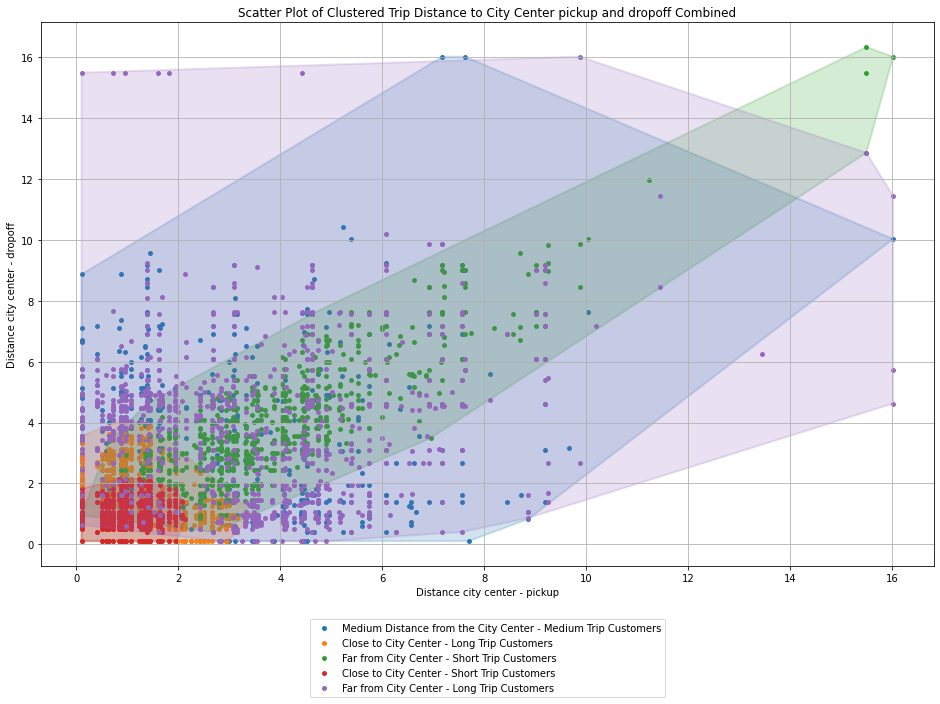

In [33]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='distance_to_city_center_pickup', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Distance city center - pickup', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered Trip Distance to City Center pickup and dropoff Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

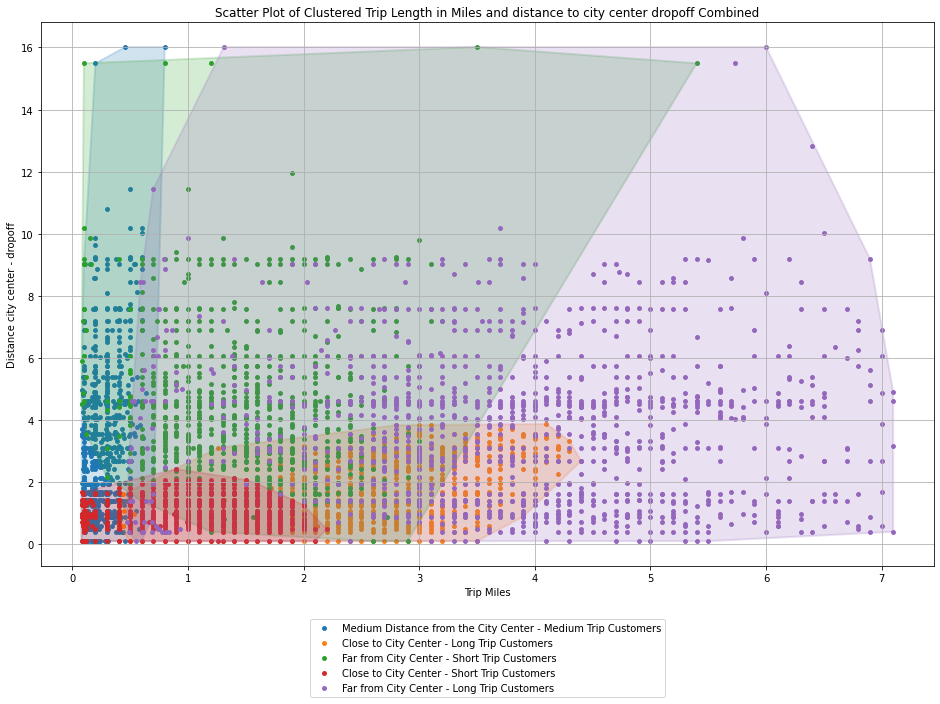

In [60]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='Trip_Miles', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Miles', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered Trip Length in Miles and distance to city center dropoff Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

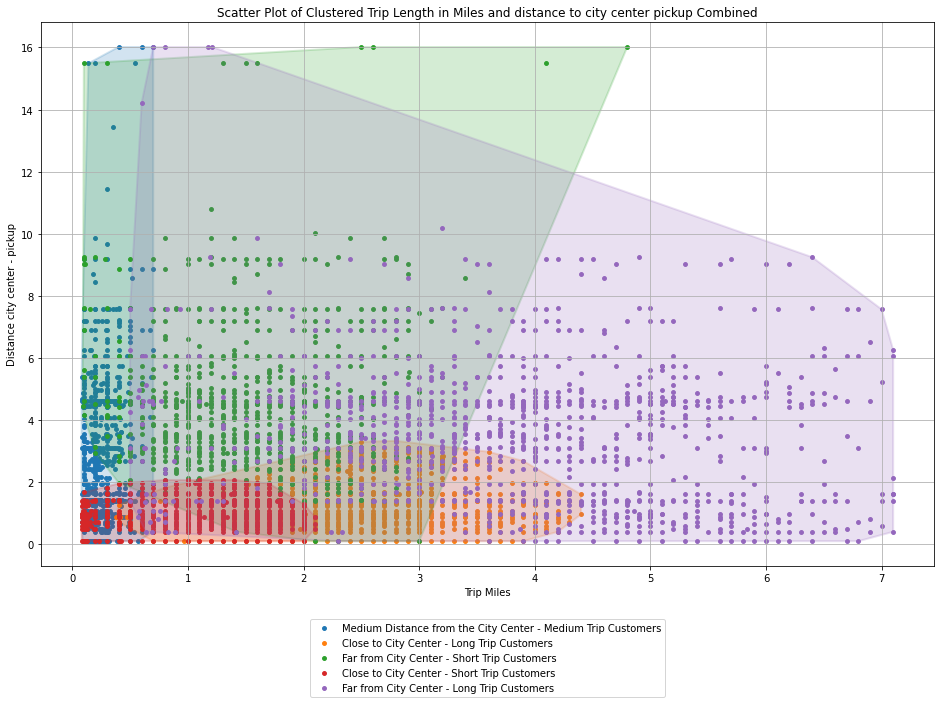

In [35]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='Trip_Miles', y_col='distance_to_city_center_pickup', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Miles', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered Trip Length in Miles and distance to city center pickup Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

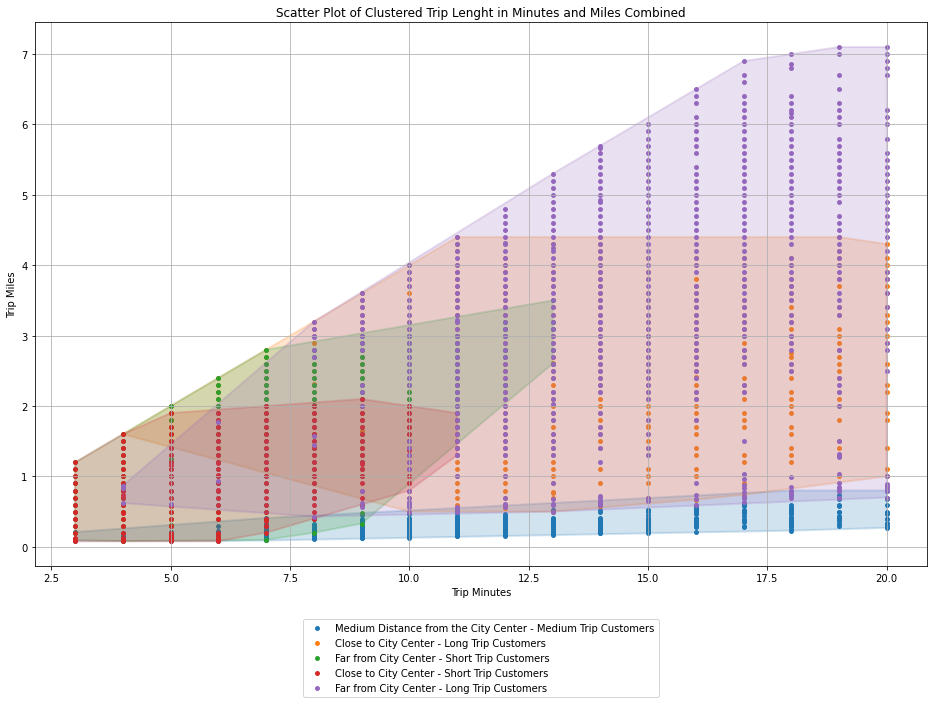

In [34]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='Trip_Minutes', y_col='Trip_Miles', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Trip Miles", plot_title='Scatter Plot of Clustered Trip Lenght in Minutes and Miles Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

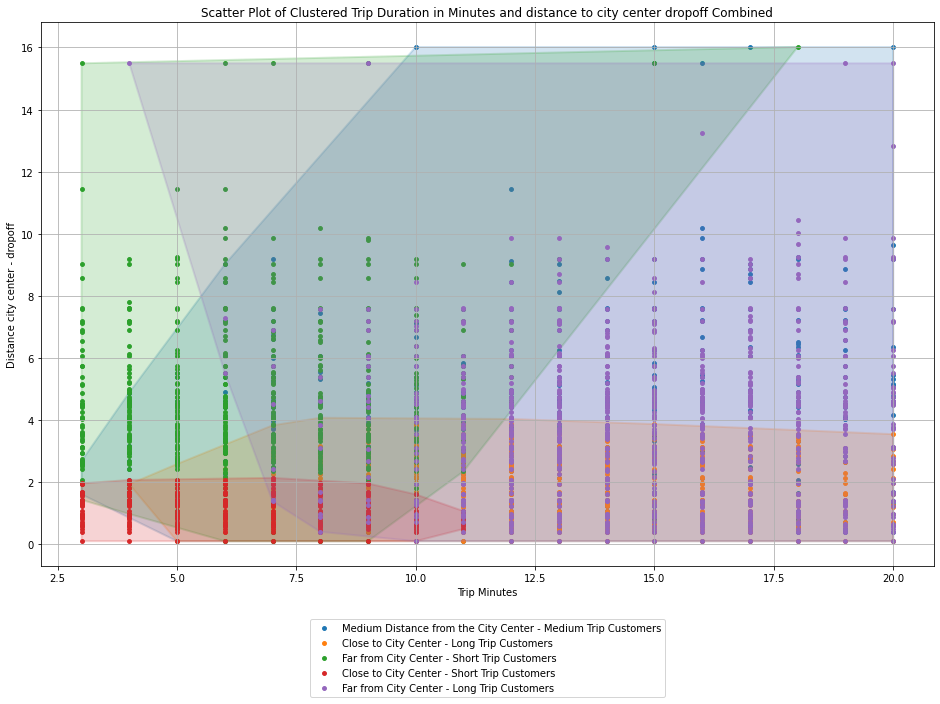

In [62]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='Trip_Minutes', y_col='distance_to_city_center_dropoff', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Distance city center - dropoff", plot_title='Scatter Plot of Clustered Trip Duration in Minutes and distance to city center dropoff Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

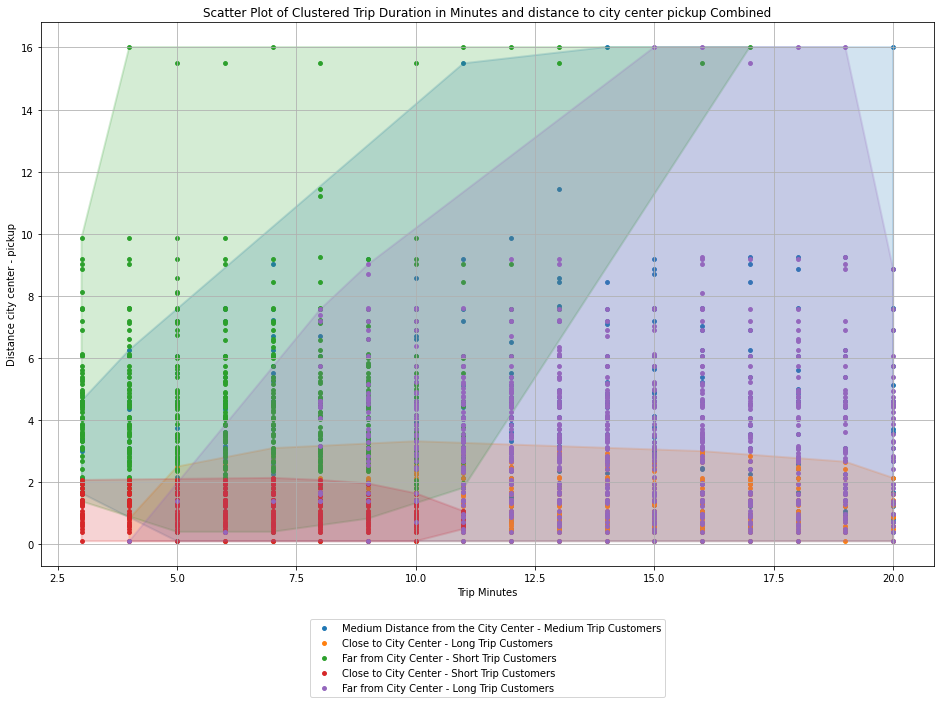

In [63]:
# Call the function to plot the scatter plot with convex hull boundaries and smaller data points
plot_scatter_with_hulls(df_chicago_location.sample(n=10_000), x_col='Trip_Minutes', y_col='distance_to_city_center_pickup', cluster_col='cluster', label_col="Cluster_Label", size_tuple=(16, 10), 
                        dp_size=15, x_label='Trip Minutes', y_label="Distance city center - pickup", plot_title='Scatter Plot of Clustered Trip Duration in Minutes and distance to city center pickup Combined',
                        leg_loc='lower center', anchor=(0.5, -0.25))

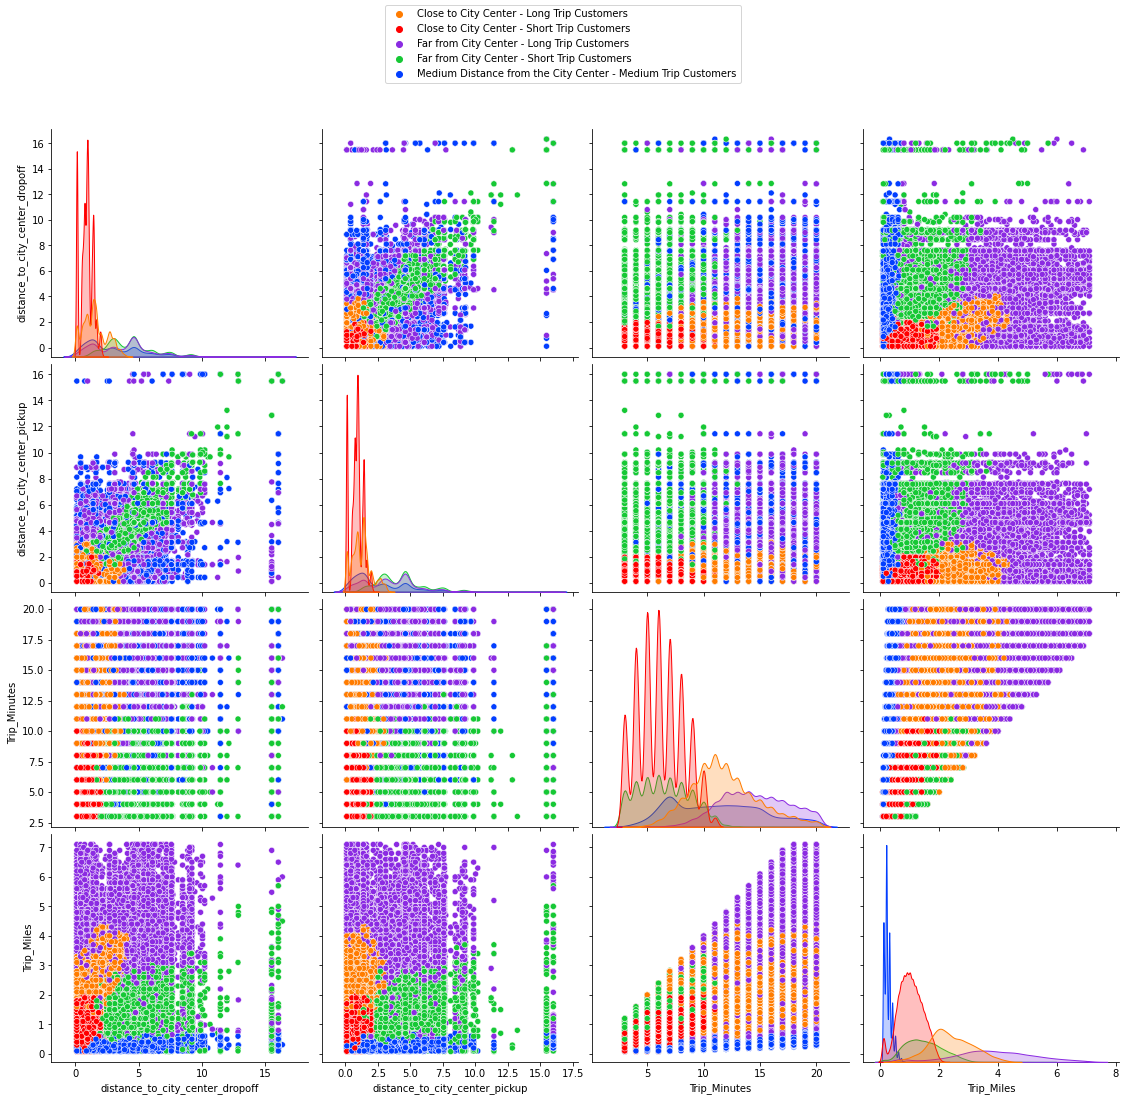

In [61]:
colors = {
          "Medium Distance from the City Center - Medium Trip Customers" : '#023EFF', 
            "Close to City Center - Long Trip Customers":'#FF7C00',
            "Far from City Center - Short Trip Customers": '#16C835',
             "Close to City Center - Short Trip Customers": '#FF0000',
          "Far from City Center - Long Trip Customers": '#8B2BE2'}


g = sns.pairplot(data=df_chicago_location[['distance_to_city_center_dropoff','distance_to_city_center_pickup', 'Trip_Minutes' ,'Trip_Miles', 'Cluster_Label']].sample(100_000),
             hue = 'Cluster_Label', palette=colors, height=4, aspect=1)

#styling the output
handles = g._legend_data.values()
labels = g._legend_data.keys()
g._legend.remove()
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1)
g.fig.subplots_adjust(top=0.89, bottom=0.08)

### 3.7.5 Evaluation

`Cluster 0 -` __Medium Distance from the City Center - Medium Trip Customers__ <br>
Here are all trips with distance from short, over medium to long. However the distance is quite short with a long driving time. 

`Cluster 1 -` __Close to City Center - Long Trip Customers__  <br>
This cluster represents the trips that are close to the center but nevertheless needing much time and driving sometimes a relatively many miles. This can be, as assumed in chapter 3.4, because we have a lot of traffic within the center or maybe because the start and end are indeed close to the center, but not close to each other.

`Cluster 2 -` __Far from City Center - Short Trip Customers__  <br>
This cluster contains trips that are far away from the center of the city, but nevertheless only driving a couple miles and minutes. Because we have these patterns (short time and distance, but far away from center for both pickup and dropoff), we assume that these are the trips that are driven from one point outside the center to another one close to it.

`Cluster 3 -` __Close to City Center - Short Trip Customers__  <br>
This cluster represents the trips that are close to ths city center and need, as expected, only a few minutes. The number of miles driven is also quite low. Here short distances are covered within the center.

`Cluster 4 -` __Far from City Center - Long Trip Customers__  <br>
The trips in this cluster are far away from city center. In addition to that the trips have a long driving time and cover a long distance (much miles which are driven). In opposite to cluster 2, this can be the trips that start from one point outside the city center and end in another one, which is far away from the pickup one. This could result in a long distance and long driving time.